<a href="https://colab.research.google.com/github/parmigggiana/ml-ids/blob/main/IDS_CICIDS2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web attack detection using CICIDS2017 dataset

This is an edited version of the original https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/web-attack-detection.ipynb

I have adapted the script to use the [corrected CIC-IDS-2017 dataset](https://intrusion-detection.distrinet-research.be/CNS2022/index.html).
Instead of selecting a single day, I used the whole dataset (~2 mil. entries).
The script was written and corrected iterating on only one of those days, to make it easier to test that everything was working as intended. After it was done, I re-ran it with all the available data and saved the results.
I changed the math in the undersampling section to make it easier and more direct. I also chose to only undersample based on probability instead of having an hard limit. Given the size of the dataset, this is mostly ininfluent.
I have also re-done the feature selection and analysis.
The original trained and selected features on the whole dataset, which raises a question about overfitting. After the data preparation I took out a portion of the dataset which was never used again, if not for the final test after everything else was set.  
After that, I added testing on the corrected CSE-CIC-IDS-2018 dataset to verify the model's generalization capability.

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

## Data preprocessing

Source: https://github.com/bozbil/Anomaly-Detection-in-Networks-Using-Machine-Learning/blob/master/01_preprocessing.ipynb [Kostas2018].

### Download and clean data

I will use the corrected CIC-IDS-2017 instead of the original.

In [2]:
!wget https://intrusion-detection.distrinet-research.be/CNS2022/Datasets/CICIDS2017_improved.zip -O dataset.zip
!unzip -u -d Corrected_CICIDS2017/ dataset.zip 

Using encoding='latin' avoids the UnicodeDecodeError we get otherwise

In [3]:
from pathlib import Path
li = []
for filename in Path('./Corrected_CICIDS2017/').glob('*.csv'):
  li.append(pd.read_csv(filename, index_col=0, encoding='latin'))
df = pd.concat(li, axis=0, ignore_index=True)

In [4]:
df

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label,Attempted Category
0,192.168.10.50-192.168.10.3-56108-3268-6,192.168.10.50,56108,192.168.10.3,3268,6,2017-07-07 11:59:50.315195,112740690,32,16,...,343,1.610540e+07,4.988048e+05,16399772,15375229,-1,-1,112740690,BENIGN,-1
1,192.168.10.50-192.168.10.3-42144-389-6,192.168.10.50,42144,192.168.10.3,389,6,2017-07-07 11:59:50.316273,112740560,32,16,...,285,1.610543e+07,4.987937e+05,16399782,15375263,-1,-1,112740560,BENIGN,-1
2,8.6.0.1-8.0.6.4-0-0-0,8.6.0.1,0,8.0.6.4,0,0,2017-07-07 12:00:31.388567,113757377,545,0,...,19,1.221036e+07,6.935824e+06,20757030,5504997,-1,-1,0,BENIGN,-1
3,192.168.10.25-224.0.0.251-5353-5353-17,192.168.10.25,5353,224.0.0.251,5353,17,2017-07-07 12:00:42.903850,91997219,388,0,...,16,1.319764e+07,5.826905e+06,19776791,5817470,-1,-1,0,BENIGN,-1
4,192.168.10.25-17.253.14.125-123-123-17,192.168.10.25,123,17.253.14.125,123,17,2017-07-07 12:00:42.430758,66966070,6,6,...,1968172,6.497443e+07,0.000000e+00,64974431,64974431,-1,-1,0,BENIGN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099971,192.168.10.8-198.51.152.183-59942-80-6,192.168.10.8,59942,198.51.152.183,80,6,2017-07-05 17:50:58.592115,5074745,7,6,...,0,0.000000e+00,0.000000e+00,0,0,-1,-1,5074745,BENIGN,-1
2099972,192.168.10.16-192.168.10.3-27998-53-17,192.168.10.16,27998,192.168.10.3,53,17,2017-07-05 13:03:34.820723,209,2,2,...,0,0.000000e+00,0.000000e+00,0,0,-1,-1,0,BENIGN,-1
2099973,192.168.10.51-23.208.163.130-58030-443-6,192.168.10.51,58030,23.208.163.130,443,6,2017-07-05 13:04:59.752472,116281383,24,21,...,23012,9.639210e+06,1.321437e+06,10024910,5443180,-1,-1,116281383,BENIGN,-1
2099974,192.168.10.5-192.168.10.3-51818-53-17,192.168.10.5,51818,192.168.10.3,53,17,2017-07-05 18:20:02.014027,149,2,2,...,0,0.000000e+00,0.000000e+00,0,0,-1,-1,0,BENIGN,-1


In [5]:
df.shape

(2099976, 90)

As for the differences between the features, aside for a couple of names that changed slightly, the corrected datasets adds 5 features: 'Fwd RST Flags', 'Bwd RST Flags', 'ICMP Code', 'ICMP Type', 'Total TCP Flow Time'. It also removed the duplicated feature 'Fwd Header Length.1'.
Other than that, there's a column 'Attempted'. This should not be treated as a feature by the machine learning model. As suggested by the paper authors, we treat all those samples ad benign.

In [6]:
def clean_attempted(row):
  if row['Attempted Category'] != -1:
    row['Label'] = 'BENIGN'
  return row

df = df.apply(clean_attempted, axis=1)
df = df.drop(columns='Attempted Category')

When assessing the distribution of labels, it turns out that out of 2099976 records there are many benign records - 1594545 to be exact.

In [7]:
df['Label'].unique()

array(['BENIGN', 'Botnet', 'Portscan', 'DDoS', 'Web Attack - Brute Force',
       'Infiltration', 'Infiltration - Portscan', 'Web Attack - XSS',
       'Web Attack - SQL Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS Slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

In [8]:
df['Label'].value_counts()

Label
BENIGN                        1594545
Portscan                       159066
DoS Hulk                       158468
DDoS                            95144
Infiltration - Portscan         71767
DoS GoldenEye                    7567
FTP-Patator                      3972
DoS Slowloris                    3859
SSH-Patator                      2961
DoS Slowhttptest                 1740
Botnet                            736
Web Attack - Brute Force           73
Infiltration                       36
Web Attack - XSS                   18
Web Attack - SQL Injection         13
Heartbleed                         11
Name: count, dtype: int64

Delete blank records. This shouldn't make a difference since the new dataset already has no blank records.

In [9]:
df = df.drop(df[pd.isnull(df['Flow ID'])].index)
df.shape

(2099976, 89)

The "Flow Bytes/s" and "Flow Packets/s" columns have non-numerical values, replace them.

In [10]:
df.replace('Infinity', -1, inplace=True)
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)

Replace the NaN values and infinity values with -1.

In [11]:
df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

Convert string characters to numbers, use LabelEncoder, not OneHotEncoder.

In [12]:
string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

['Flow ID', 'Src IP', 'Dst IP', 'Timestamp']

In [13]:
le = preprocessing.LabelEncoder()
df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))

In [14]:
df.to_csv("web_attacks_unbalanced.csv", index=False)

### Undersampling against unbalance

Dataset is unbalanced: total records = 2099976, "BENIGN" records = 1594545, records with attacks much less: 11 + 13 + 18 + 36 + 73 + 736 + 1740 + 2961 + 3859 + 3972 + 7567 + 71767 + 95144 + 158468 + 159066 = 505431.

In [15]:
df = pd.read_csv('web_attacks_unbalanced.csv')

In [16]:
benign_total = len(df[df['Label'] == "BENIGN"])
benign_total

1594545

In [17]:
attack_total = len(df[df['Label'] != "BENIGN"])
attack_total

505431

In [18]:
df['Label'].value_counts()

Label
BENIGN                        1594545
Portscan                       159066
DoS Hulk                       158468
DDoS                            95144
Infiltration - Portscan         71767
DoS GoldenEye                    7567
FTP-Patator                      3972
DoS Slowloris                    3859
SSH-Patator                      2961
DoS Slowhttptest                 1740
Botnet                            736
Web Attack - Brute Force           73
Infiltration                       36
Web Attack - XSS                   18
Web Attack - SQL Injection         13
Heartbleed                         11
Name: count, dtype: int64

We use **undersampling** to correct class imbalances: we remove most of the "BENIGN" records.

Form a balanced dataset web_attacks_balanced.csv in proportion: 70% benign data, 30% attacks (2099976 total: x attacks, 1179339 benign).

Algorithm to form a balanced df_balanced dataset:

* All the records with the attacks are copied to the new dataset.
* There are two conditions for copying "BENIGN" records to the new dataset:

     1. The next record is copyied with the benign_inc_probability.
     2. The total number of "BENIGN" records must not exceed the limit of 5087 records.

Сalculate the probability of copying a "BENIGN" record.

In [19]:
total_samples = len(df[df['Label'] != 'BENIGN']) // 0.3
benign_included_max = round(total_samples * 0.7)
benign_inc_probability = benign_included_max / benign_total
print(benign_included_max, benign_inc_probability)

1179339 0.7396084776534999


Copy records from df to df_balanced, save dataset **web_attacks_balanced.csv**.

In [20]:
import random
indexes = []
benign_included_count = 0
for index, row in df.iterrows():
    if (row['Label'] == "BENIGN"):
      # Have we achieved 70%?
      #if benign_included_count > benign_included_max: continue
      # Copying with benign_inc_probability
      if random.random() > benign_inc_probability: continue
      benign_included_count += 1

    indexes.append(index)

df_balanced = df.loc[indexes]

In [21]:
df_balanced['Label'].value_counts()

Label
BENIGN                        1179978
Portscan                       159066
DoS Hulk                       158468
DDoS                            95144
Infiltration - Portscan         71767
DoS GoldenEye                    7567
FTP-Patator                      3972
DoS Slowloris                    3859
SSH-Patator                      2961
DoS Slowhttptest                 1740
Botnet                            736
Web Attack - Brute Force           73
Infiltration                       36
Web Attack - XSS                   18
Web Attack - SQL Injection         13
Heartbleed                         11
Name: count, dtype: int64

In [22]:
len(df_balanced[df_balanced['Label'] == 'BENIGN'])/len(df_balanced)

0.7001137409376597

In [23]:
df_balanced.to_csv("web_attacks_balanced.csv", index=False)

### Preparing data for training

In [24]:
df = pd.read_csv('web_attacks_balanced.csv')

The Label column is encoded as follows: "BENIGN" = 0, attack = 1.

In [25]:
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

7 features (Flow ID, Source IP, Source Port, Destination IP, Destination Port, Protocol, Timestamp) are excluded from the dataset. The hypothesis is that the "shape" of the data being transmitted is more important than these attributes. In addition, ports and addresses can be substituted by an attacker, so it is better that the ML algorithm does not take these features into account in training [Kostas2018].

In [26]:
excluded = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp']
df = df.drop(columns=excluded)

In [27]:
df.to_csv("definitive_dataset.csv", index=False)

## Feature importance

In [28]:
df = df.sample(500000) # randomly take 500k samples for hyperparameters selection
y = df['Label'].values
X = df.drop(columns=['Label'])
print(X.shape, y.shape)

(500000, 81) (500000,)


In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=241)

### Evaluation of importance using RandomForestClassifier.feature_importances_

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150, random_state=42, oob_score=True)
rf.fit(X_train, y_train)
# Score = mean accuracy on the given test data and labels
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f} \nOut-of-bag Score: {:.2f}'
      .format(rf.score(X_train, y_train), rf.score(X_test, y_test), rf.oob_score_))

R^2 Training Score: 1.00 
R^2 Validation Score: 1.00 
Out-of-bag Score: 1.00


We select all the features with importance at least 1%

In [31]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
webattack_features = []

for index, i in enumerate(indices):
    if importances[i] >= 0.01:
      webattack_features.append(features[i])
    print(f'{index+1}. \t #{i} \t {importances[i]:.3f} \t {features[i]}')

1. 	 #46 	 0.080 	 RST Flag Count
2. 	 #12 	 0.057 	 Bwd Packet Length Std
3. 	 #42 	 0.046 	 Packet Length Std
4. 	 #55 	 0.044 	 Bwd Segment Size Avg
5. 	 #3 	 0.043 	 Total Length of Fwd Packet
6. 	 #63 	 0.042 	 Subflow Fwd Bytes
7. 	 #5 	 0.041 	 Fwd Packet Length Max
8. 	 #43 	 0.037 	 Packet Length Variance
9. 	 #37 	 0.035 	 Fwd Packets/s
10. 	 #7 	 0.034 	 Fwd Packet Length Mean
11. 	 #17 	 0.031 	 Flow IAT Max
12. 	 #40 	 0.030 	 Packet Length Max
13. 	 #11 	 0.030 	 Bwd Packet Length Mean
14. 	 #54 	 0.025 	 Fwd Segment Size Avg
15. 	 #53 	 0.023 	 Average Packet Size
16. 	 #41 	 0.022 	 Packet Length Mean
17. 	 #0 	 0.020 	 Flow Duration
18. 	 #9 	 0.020 	 Bwd Packet Length Max
19. 	 #14 	 0.020 	 Flow Packets/s
20. 	 #80 	 0.018 	 Total TCP Flow Time
21. 	 #65 	 0.017 	 Subflow Bwd Bytes
22. 	 #47 	 0.016 	 PSH Flag Count
23. 	 #39 	 0.014 	 Packet Length Min
24. 	 #24 	 0.014 	 Bwd IAT Total
25. 	 #66 	 0.012 	 FWD Init Win Bytes
26. 	 #13 	 0.012 	 Flow Bytes/s
27. 	 #48

Visualize what we're left with

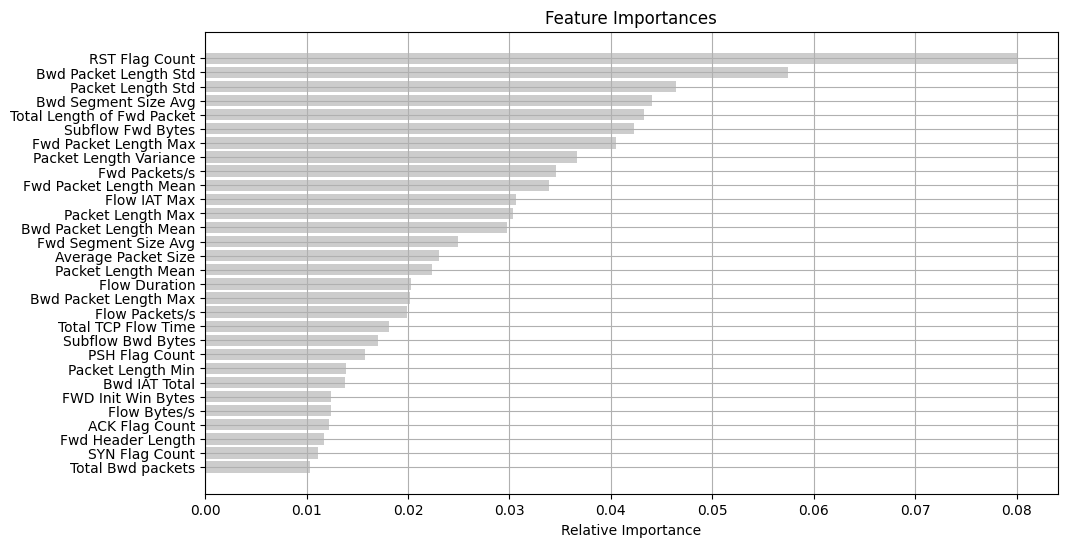

In [32]:
indices = np.argsort(importances)[-len(webattack_features):]
plt.rcParams['figure.figsize'] = (11, 6)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#cccccc', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.show()

In [33]:
from sklearn.metrics import confusion_matrix

y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[69901,     3],
       [   14, 30082]])

## Analysis of selected features

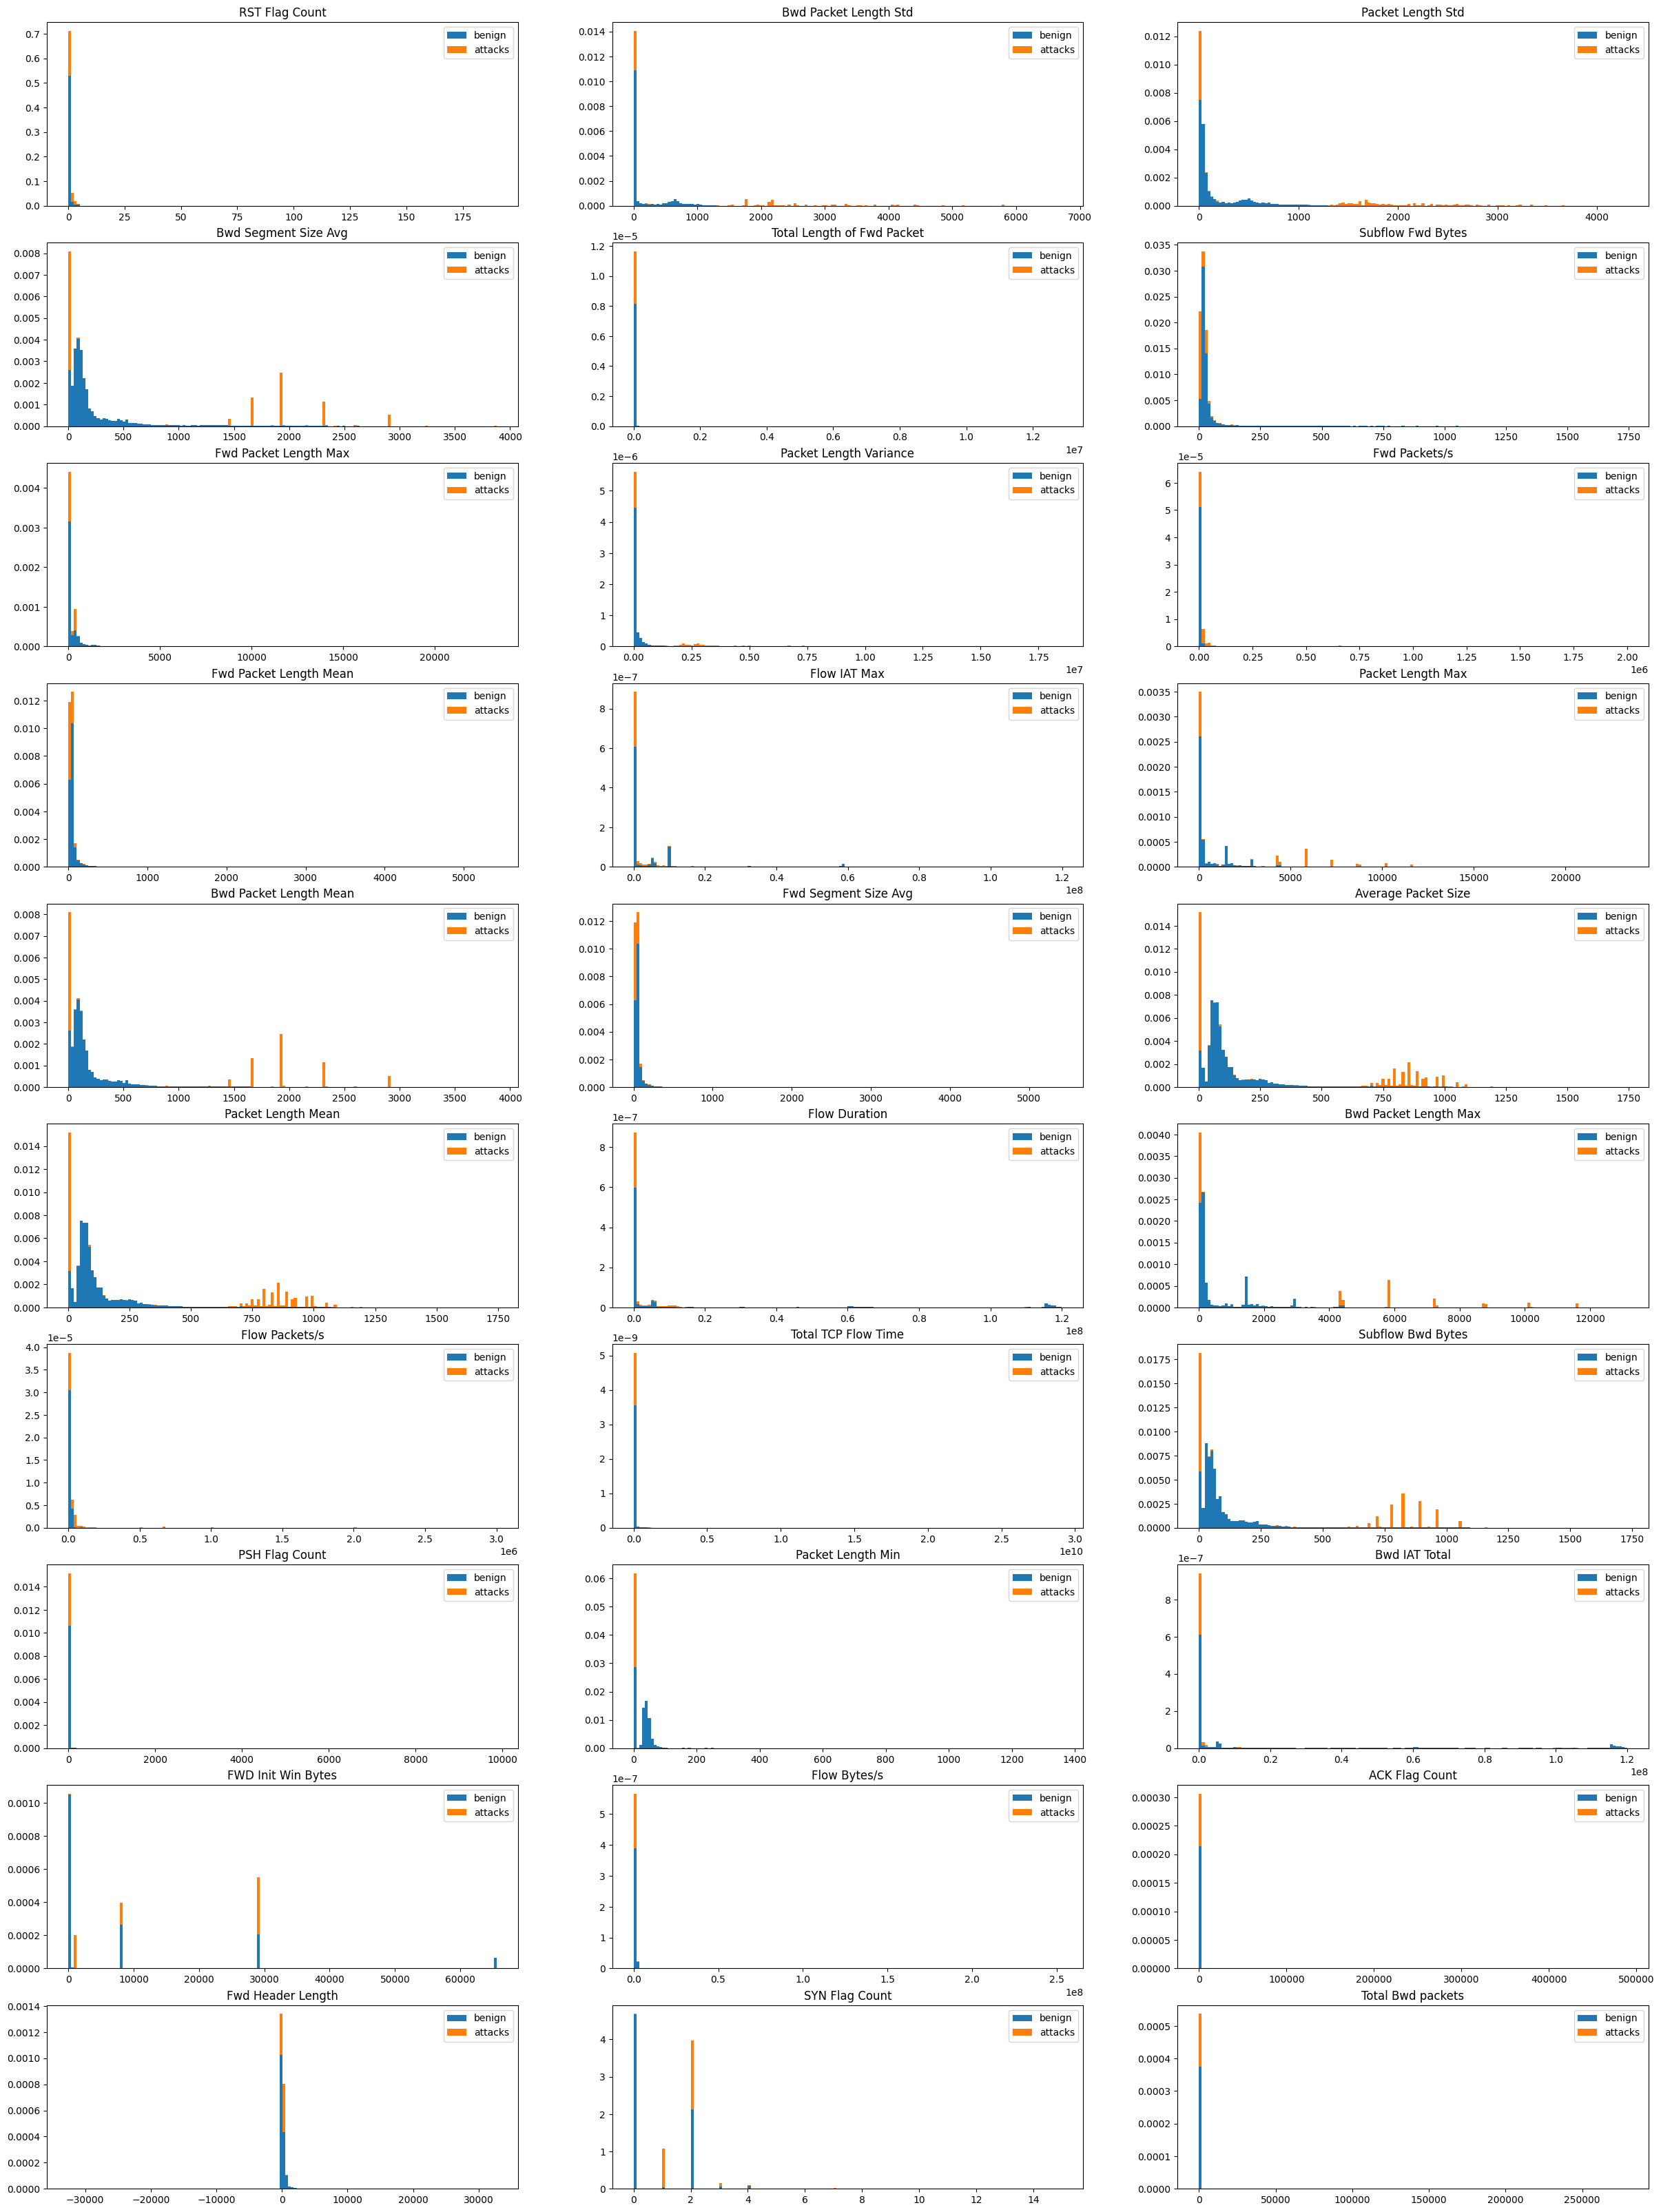

In [34]:

frame_attacks = df[df['Label'] == 1]
frame_benigns = df[df['Label'] == 0]
plt.figure(figsize=(30,45))
for i, feat in enumerate(webattack_features):
    plt.subplot(len(webattack_features)//3+1, 3, i+1)
    x1 = sorted(frame_benigns[feat])
    x2 = sorted(frame_attacks[feat])
    fr = [x1, x2]
    plt.hist([x for x in fr if x != (0, 0)], bins=150, density=True, stacked=True)
    plt.title(feat)
    plt.legend(['benign', 'attacks'])
plt.show()

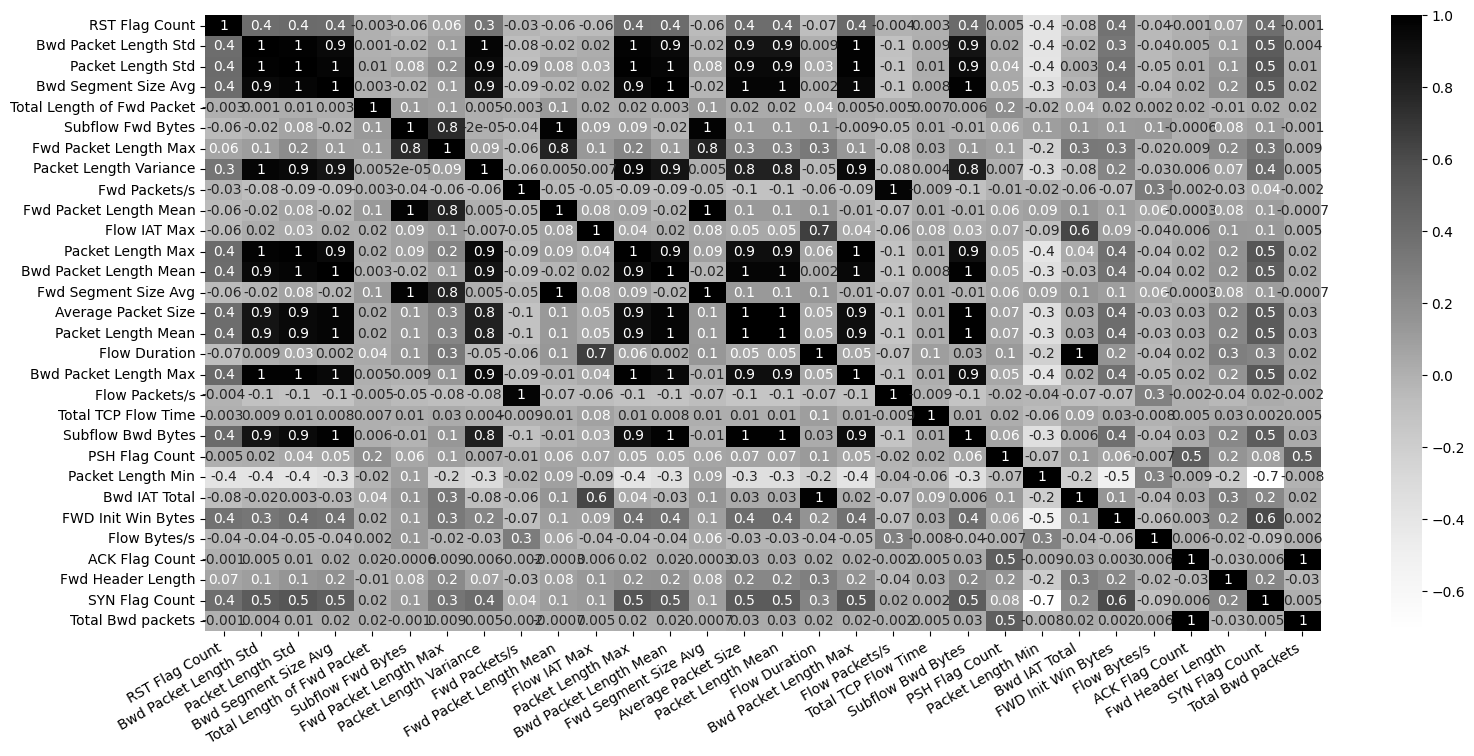

In [35]:
import seaborn as sns
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (18, 8)
g = sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys')
g.set_xticklabels(g.get_xticklabels(), verticalalignment='top', horizontalalignment='right', rotation=30);
plt.show()

Remove correlated features.

In [36]:
to_be_removed = {'Packet Length Std', 'Bwd Packet Length Std', 'Bwd Segment Size Avg', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Packet Length Max', 'Packet length Max', 'Packet Length Mean', 'Average Packet Size', 'Subflow Bwd Bytes', 'Fwd RST Flags', 'Subflow Fwd Bytes', 'Fwd Segment Size Avg'}
webattack_features = [item for item in webattack_features if item not in to_be_removed]

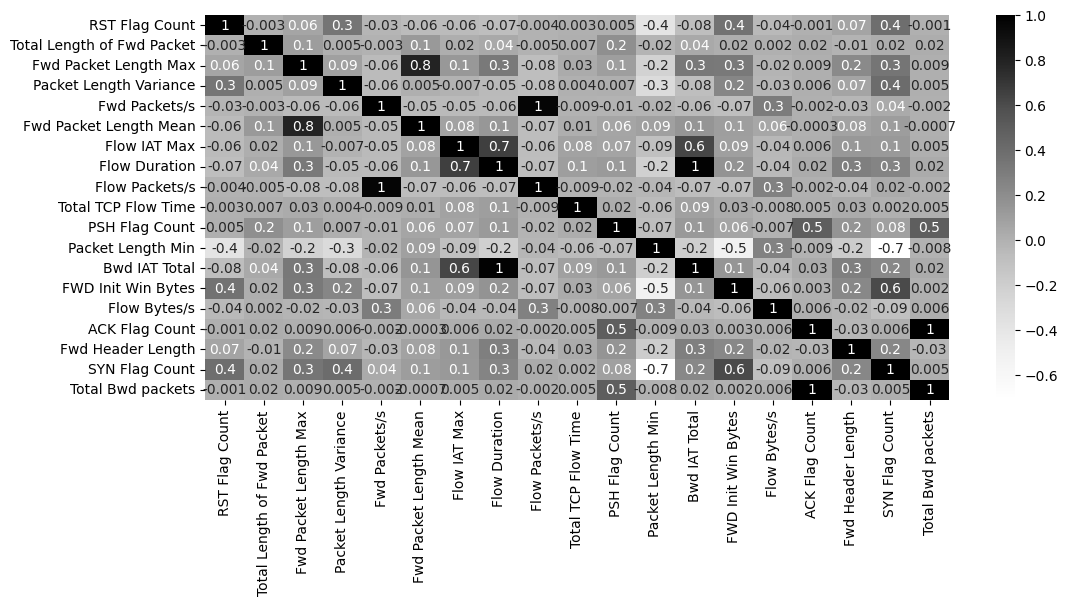

In [37]:
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (12, 5)
sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys');

In [38]:
print(webattack_features)

['RST Flag Count', 'Total Length of Fwd Packet', 'Fwd Packet Length Max', 'Packet Length Variance', 'Fwd Packets/s', 'Fwd Packet Length Mean', 'Flow IAT Max', 'Flow Duration', 'Flow Packets/s', 'Total TCP Flow Time', 'PSH Flag Count', 'Packet Length Min', 'Bwd IAT Total', 'FWD Init Win Bytes', 'Flow Bytes/s', 'ACK Flag Count', 'Fwd Header Length', 'SYN Flag Count', 'Total Bwd packets']


## Hyperparameter selection

### Grid search

In [39]:
parameters = {'n_estimators': [30, 50, 80],
              'min_samples_leaf': [4, 3, 2],
              'max_features': ['sqrt', 'log2', 5, 12, None],
              'max_depth': [3, 5, 8, None]}

In [40]:
from sklearn.model_selection import GridSearchCV
X_train = X_train[webattack_features]
X_test = X_test[webattack_features]

rfc = RandomForestClassifier(criterion='gini', random_state=6, oob_score=True, n_jobs=-1)
gcv = GridSearchCV(rfc, parameters, scoring='f1', refit='f1', cv=3, return_train_score=True, verbose=10, n_jobs=2)
gcv.fit(X_train, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV 2/3; 1/240] START max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=20
[CV 1/3; 1/240] START max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 1/240] END max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=20;, score=(train=0.973, test=0.972) total time=   1.5s
[CV 2/3; 1/240] END max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=20;, score=(train=0.973, test=0.973) total time=   1.6s
[CV 3/3; 1/240] START max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=20
[CV 1/3; 2/240] START max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 1/240] END max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=20;, score=(train=0.973, test=0.973) total time=   1.6s
[CV 2/3; 2/240] START max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 2/240] END max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=30;, score=(train=0.971, test=0.971) total time=   2.4s
[CV 3/3; 2/240] START max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 2/240] END max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=30;, score=(train=0.970, test=0.971) total time=   2.1s
[CV 1/3; 3/240] START max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 2/240] END max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=30;, score=(train=0.971, test=0.971) total time=   2.0s
[CV 2/3; 3/240] START max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=50
[CV 1/3; 3/240] END max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=50;, score=(train=0.968, test=0.968) total time=   3.3s
[CV 3/3; 3/240] START max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=50
[CV 2/3; 3/240] END max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=50;, score=(train=0.968, test=0.969) total time=   3.4s
[CV 1/3; 4/240] START max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=70
[CV 3/3; 3/240] END max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=50;, score=(train=0.968, test=0.968) total time=   3.6s
[CV 2/3; 4/240] START max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=70
[CV 1/3; 4/240] END max_depth=3, max_features=sqrt, min_samples_leaf=4, n_es

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 5/240] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=20;, score=(train=0.973, test=0.972) total time=   1.1s
[CV 2/3; 5/240] START max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=20
[CV 3/3; 4/240] END max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=70;, score=(train=0.968, test=0.968) total time=   3.8s
[CV 3/3; 5/240] START max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 5/240] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=20;, score=(train=0.973, test=0.973) total time=   1.6s
[CV 1/3; 6/240] START max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 5/240] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=20;, score=(train=0.973, test=0.973) total time=   1.4s
[CV 2/3; 6/240] START max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 6/240] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=30;, score=(train=0.971, test=0.971) total time=   2.1s
[CV 3/3; 6/240] START max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 6/240] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=30;, score=(train=0.970, test=0.971) total time=   2.1s
[CV 1/3; 7/240] START max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 6/240] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=30;, score=(train=0.971, test=0.971) total time=   2.4s
[CV 2/3; 7/240] START max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=50
[CV 1/3; 7/240] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=50;, score=(train=0.968, test=0.968) total time=   3.3s
[CV 3/3; 7/240] START max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=50
[CV 2/3; 7/240] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=50;, score=(train=0.968, test=0.969) total time=   3.5s
[CV 1/3; 8/240] START max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=70
[CV 3/3; 7/240] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=50;, score=(train=0.968, test=0.968) total time=   3.6s
[CV 2/3; 8/240] START max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=70
[CV 1/3; 8/240] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_es

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 9/240] END max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.972) total time=   1.1s
[CV 2/3; 9/240] START max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=20
[CV 3/3; 8/240] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=70;, score=(train=0.968, test=0.968) total time=   3.6s
[CV 3/3; 9/240] START max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 9/240] END max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.973) total time=   1.4s
[CV 1/3; 10/240] START max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 9/240] END max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.973) total time=   1.1s
[CV 2/3; 10/240] START max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 10/240] END max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=30;, score=(train=0.971, test=0.971) total time=   2.0s


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/basilef/Documents/Repos/ml-ids/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/3; 10/240] END max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=30;, score=(train=0.970, test=0.971) total time=   1.9s
[CV 3/3; 10/240] START max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=30
[CV 1/3; 11/240] START max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 10/240] END max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=30;, score=(train=0.971, test=0.971) total time=   1.8s
[CV 2/3; 11/240] START max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=50
[CV 1/3; 11/240] END max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=50;, score=(train=0.968, test=0.968) total time=   3.5s
[CV 3/3; 11/240] START max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=50
[CV 2/3; 11/240] END max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=50;, score=(train=0.968, test=0.969) total time=   3.4s
[CV 1/3; 12/240] START max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=70
[CV 3/3; 11/240] END max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=50;, score=(train=0.968, test=0.968) total time=   3.9s
[CV 2/3; 12/240] START max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=70
[CV 1/3; 12/240] END max_depth=3, max_features=sqrt, min_samples_lea

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 13/240] END max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=20;, score=(train=0.973, test=0.972) total time=   1.1s
[CV 2/3; 13/240] START max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=20
[CV 3/3; 12/240] END max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=70;, score=(train=0.968, test=0.968) total time=   3.8s
[CV 3/3; 13/240] START max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 13/240] END max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=20;, score=(train=0.973, test=0.973) total time=   1.5s
[CV 1/3; 14/240] START max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 13/240] END max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=20;, score=(train=0.973, test=0.973) total time=   1.5s
[CV 2/3; 14/240] START max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 14/240] END max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=30;, score=(train=0.971, test=0.971) total time=   2.2s
[CV 3/3; 14/240] START max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 14/240] END max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=30;, score=(train=0.970, test=0.971) total time=   2.1s
[CV 1/3; 15/240] START max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 14/240] END max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=30;, score=(train=0.971, test=0.971) total time=   2.6s
[CV 2/3; 15/240] START max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=50
[CV 1/3; 15/240] END max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=50;, score=(train=0.968, test=0.968) total time=   3.5s
[CV 3/3; 15/240] START max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=50
[CV 2/3; 15/240] END max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=50;, score=(train=0.968, test=0.969) total time=   3.4s
[CV 1/3; 16/240] START max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=70
[CV 3/3; 15/240] END max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=50;, score=(train=0.968, test=0.968) total time=   3.7s
[CV 2/3; 16/240] START max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=70
[CV 1/3; 16/240] END max_depth=3, max_features=log2, min_samples_lea

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 17/240] END max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=20;, score=(train=0.973, test=0.972) total time=   1.2s
[CV 2/3; 17/240] START max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=20
[CV 3/3; 16/240] END max_depth=3, max_features=log2, min_samples_leaf=4, n_estimators=70;, score=(train=0.968, test=0.968) total time=   3.9s
[CV 3/3; 17/240] START max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 17/240] END max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=20;, score=(train=0.973, test=0.973) total time=   1.5s
[CV 1/3; 18/240] START max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 17/240] END max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=20;, score=(train=0.973, test=0.973) total time=   1.7s
[CV 2/3; 18/240] START max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 18/240] END max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=30;, score=(train=0.971, test=0.971) total time=   2.2s
[CV 3/3; 18/240] START max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 18/240] END max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=30;, score=(train=0.970, test=0.971) total time=   2.0s


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 18/240] END max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=30;, score=(train=0.971, test=0.971) total time=   1.6s
[CV 2/3; 19/240] START max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=50
[CV 1/3; 19/240] START max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=50
[CV 2/3; 19/240] END max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=50;, score=(train=0.968, test=0.969) total time=   3.2s
[CV 3/3; 19/240] START max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=50
[CV 1/3; 19/240] END max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=50;, score=(train=0.968, test=0.968) total time=   4.0s
[CV 1/3; 20/240] START max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=70
[CV 3/3; 19/240] END max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=50;, score=(train=0.968, test=0.968) total time=   3.9s
[CV 2/3; 20/240] START max_depth=3, max_features=log2, min_samples_l

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 21/240] END max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.972) total time=   1.1s
[CV 2/3; 21/240] START max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=20
[CV 3/3; 20/240] END max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=70;, score=(train=0.968, test=0.968) total time=   4.1s
[CV 3/3; 21/240] START max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 21/240] END max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.973) total time=   1.6s
[CV 1/3; 22/240] START max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 21/240] END max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.973) total time=   1.8s
[CV 2/3; 22/240] START max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 22/240] END max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=30;, score=(train=0.971, test=0.971) total time=   2.1s
[CV 3/3; 22/240] START max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 22/240] END max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=30;, score=(train=0.970, test=0.971) total time=   2.1s
[CV 1/3; 23/240] START max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 22/240] END max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=30;, score=(train=0.971, test=0.971) total time=   2.2s
[CV 2/3; 23/240] START max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=50
[CV 1/3; 23/240] END max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=50;, score=(train=0.968, test=0.968) total time=   3.3s
[CV 3/3; 23/240] START max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=50
[CV 2/3; 23/240] END max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=50;, score=(train=0.968, test=0.969) total time=   3.3s
[CV 1/3; 24/240] START max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=70
[CV 3/3; 23/240] END max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=50;, score=(train=0.968, test=0.968) total time=   3.8s
[CV 2/3; 24/240] START max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=70
[CV 1/3; 24/240] END max_depth=3, max_features=log2, min_samples_lea

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 25/240] END max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=20;, score=(train=0.974, test=0.974) total time=   1.3s
[CV 2/3; 25/240] START max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=20
[CV 3/3; 24/240] END max_depth=3, max_features=log2, min_samples_leaf=2, n_estimators=70;, score=(train=0.968, test=0.968) total time=   4.0s
[CV 3/3; 25/240] START max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 25/240] END max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=20;, score=(train=0.972, test=0.973) total time=   1.5s
[CV 1/3; 26/240] START max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=30
[CV 3/3; 25/240] END max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=20;, score=(train=0.973, test=0.973) total time=   1.4s
[CV 2/3; 26/240] START max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 26/240] END max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=30;, score=(train=0.973, test=0.972) total time=   2.2s
[CV 3/3; 26/240] START max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 26/240] END max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=30;, score=(train=0.972, test=0.973) total time=   2.6s
[CV 1/3; 27/240] START max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 26/240] END max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=30;, score=(train=0.972, test=0.972) total time=   2.3s
[CV 2/3; 27/240] START max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=50
[CV 1/3; 27/240] END max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=50;, score=(train=0.971, test=0.971) total time=   3.4s
[CV 3/3; 27/240] START max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=50
[CV 2/3; 27/240] END max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=50;, score=(train=0.972, test=0.972) total time=   3.7s
[CV 1/3; 28/240] START max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=70
[CV 3/3; 27/240] END max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=50;, score=(train=0.970, test=0.970) total time=   3.8s
[CV 2/3; 28/240] START max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=70
[CV 1/3; 28/240] END max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=70;, scor

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 29/240] END max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=20;, score=(train=0.974, test=0.974) total time=   1.2s
[CV 2/3; 29/240] START max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=20
[CV 3/3; 28/240] END max_depth=3, max_features=5, min_samples_leaf=4, n_estimators=70;, score=(train=0.972, test=0.971) total time=   4.3s
[CV 3/3; 29/240] START max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 29/240] END max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=20;, score=(train=0.972, test=0.973) total time=   1.6s
[CV 1/3; 30/240] START max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 29/240] END max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=20;, score=(train=0.973, test=0.973) total time=   1.5s
[CV 2/3; 30/240] START max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 30/240] END max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=30;, score=(train=0.973, test=0.972) total time=   2.1s
[CV 3/3; 30/240] START max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 30/240] END max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=30;, score=(train=0.972, test=0.973) total time=   2.0s
[CV 1/3; 31/240] START max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 30/240] END max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=30;, score=(train=0.972, test=0.972) total time=   2.3s
[CV 2/3; 31/240] START max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=50
[CV 1/3; 31/240] END max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=50;, score=(train=0.971, test=0.971) total time=   3.5s
[CV 3/3; 31/240] START max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=50
[CV 2/3; 31/240] END max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=50;, score=(train=0.972, test=0.972) total time=   3.7s
[CV 1/3; 32/240] START max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=70
[CV 3/3; 31/240] END max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=50;, score=(train=0.970, test=0.970) total time=   4.0s
[CV 2/3; 32/240] START max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=70
[CV 1/3; 32/240] END max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=70;, scor

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 33/240] END max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.974) total time=   1.2s
[CV 2/3; 33/240] START max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=20
[CV 3/3; 32/240] END max_depth=3, max_features=5, min_samples_leaf=3, n_estimators=70;, score=(train=0.972, test=0.971) total time=   4.1s
[CV 3/3; 33/240] START max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 33/240] END max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.973) total time=   1.9s
[CV 1/3; 34/240] START max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 33/240] END max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.973) total time=   1.8s
[CV 2/3; 34/240] START max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 34/240] END max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=30;, score=(train=0.973, test=0.972) total time=   2.6s
[CV 3/3; 34/240] START max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 34/240] END max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=30;, score=(train=0.972, test=0.973) total time=   2.5s
[CV 1/3; 35/240] START max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 34/240] END max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=30;, score=(train=0.972, test=0.972) total time=   2.7s
[CV 2/3; 35/240] START max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=50
[CV 1/3; 35/240] END max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.971, test=0.971) total time=   3.9s
[CV 3/3; 35/240] START max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=50
[CV 2/3; 35/240] END max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.972, test=0.972) total time=   3.9s
[CV 1/3; 36/240] START max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=70
[CV 3/3; 35/240] END max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.970) total time=   4.1s
[CV 2/3; 36/240] START max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=70
[CV 1/3; 36/240] END max_depth=3, max_features=5, min_samples_leaf=2, n_estimators=70;, scor

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 37/240] END max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=20;, score=(train=0.969, test=0.968) total time=   2.0s
[CV 3/3; 37/240] START max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 37/240] END max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=20;, score=(train=0.971, test=0.972) total time=   2.7s
[CV 1/3; 38/240] START max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 37/240] END max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=20;, score=(train=0.971, test=0.971) total time=   3.2s
[CV 2/3; 38/240] START max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 38/240] END max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=30;, score=(train=0.970, test=0.969) total time=   3.7s
[CV 3/3; 38/240] START max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 38/240] END max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=30;, score=(train=0.970, test=0.971) total time=   3.7s
[CV 1/3; 39/240] START max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 38/240] END max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=30;, score=(train=0.971, test=0.971) total time=   3.7s
[CV 2/3; 39/240] START max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=50
[CV 1/3; 39/240] END max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=50;, score=(train=0.971, test=0.970) total time=   6.0s
[CV 3/3; 39/240] START max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=50
[CV 2/3; 39/240] END max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=50;, score=(train=0.971, test=0.972) total time=   6.6s
[CV 1/3; 40/240] START max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=70
[CV 3/3; 39/240] END max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=50;, score=(train=0.973, test=0.973) total time=   6.1s
[CV 2/3; 40/240] START max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=70
[CV 1/3; 40/240] END max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 41/240] END max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=20;, score=(train=0.969, test=0.968) total time=   2.7s
[CV 2/3; 41/240] START max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=20
[CV 3/3; 40/240] END max_depth=3, max_features=12, min_samples_leaf=4, n_estimators=70;, score=(train=0.973, test=0.972) total time=   7.4s
[CV 3/3; 41/240] START max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 41/240] END max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=20;, score=(train=0.971, test=0.972) total time=   2.7s
[CV 1/3; 42/240] START max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 41/240] END max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=20;, score=(train=0.971, test=0.971) total time=   2.8s
[CV 2/3; 42/240] START max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 42/240] END max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=30;, score=(train=0.970, test=0.969) total time=   3.7s
[CV 3/3; 42/240] START max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 42/240] END max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=30;, score=(train=0.970, test=0.971) total time=   3.4s
[CV 1/3; 43/240] START max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 42/240] END max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=30;, score=(train=0.971, test=0.971) total time=   3.7s
[CV 2/3; 43/240] START max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=50
[CV 1/3; 43/240] END max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=50;, score=(train=0.971, test=0.970) total time=   6.1s
[CV 3/3; 43/240] START max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=50
[CV 2/3; 43/240] END max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=50;, score=(train=0.971, test=0.972) total time=   6.3s
[CV 1/3; 44/240] START max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=70
[CV 3/3; 43/240] END max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=50;, score=(train=0.973, test=0.973) total time=   6.1s
[CV 2/3; 44/240] START max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=70
[CV 1/3; 44/240] END max_depth=3, max_features=12, min_samples_leaf=3, n_estimators=

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 45/240] END max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=20;, score=(train=0.969, test=0.968) total time=   2.8s
[CV 3/3; 45/240] START max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 45/240] END max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=20;, score=(train=0.971, test=0.972) total time=   2.5s
[CV 1/3; 46/240] START max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 45/240] END max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=20;, score=(train=0.971, test=0.971) total time=   2.8s
[CV 2/3; 46/240] START max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 46/240] END max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=30;, score=(train=0.970, test=0.969) total time=   3.4s
[CV 3/3; 46/240] START max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 46/240] END max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=30;, score=(train=0.970, test=0.971) total time=   3.8s
[CV 1/3; 47/240] START max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 46/240] END max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=30;, score=(train=0.971, test=0.971) total time=   4.0s
[CV 2/3; 47/240] START max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=50
[CV 1/3; 47/240] END max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=50;, score=(train=0.971, test=0.970) total time=   6.3s
[CV 3/3; 47/240] START max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=50
[CV 2/3; 47/240] END max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=50;, score=(train=0.971, test=0.972) total time=   6.5s
[CV 1/3; 48/240] START max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=70
[CV 3/3; 47/240] END max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=50;, score=(train=0.973, test=0.973) total time=   6.2s
[CV 2/3; 48/240] START max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=70
[CV 1/3; 48/240] END max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 48/240] END max_depth=3, max_features=12, min_samples_leaf=2, n_estimators=70;, score=(train=0.973, test=0.972) total time=   6.7s
[CV 2/3; 49/240] START max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=20
[CV 1/3; 49/240] END max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=20;, score=(train=0.968, test=0.968) total time=   3.0s
[CV 3/3; 49/240] START max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 49/240] END max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=20;, score=(train=0.967, test=0.967) total time=   3.4s
[CV 1/3; 50/240] START max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 49/240] END max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=20;, score=(train=0.968, test=0.968) total time=   4.5s
[CV 2/3; 50/240] START max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 50/240] END max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=30;, score=(train=0.968, test=0.968) total time=   5.2s
[CV 3/3; 50/240] START max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 50/240] END max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=30;, score=(train=0.967, test=0.967) total time=   5.3s
[CV 1/3; 51/240] START max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 50/240] END max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=30;, score=(train=0.968, test=0.968) total time=   4.6s
[CV 2/3; 51/240] START max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=50
[CV 1/3; 51/240] END max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=50;, score=(train=0.968, test=0.968) total time=   9.1s
[CV 3/3; 51/240] START max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=50
[CV 2/3; 51/240] END max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=50;, score=(train=0.967, test=0.967) total time=   9.4s
[CV 1/3; 52/240] START max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=70
[CV 3/3; 51/240] END max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=50;, score=(train=0.968, test=0.968) total time=   8.0s
[CV 2/3; 52/240] START max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=70
[CV 1/3; 52/240] END max_depth=3, max_features=None, min_samples_lea

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 53/240] END max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=20;, score=(train=0.968, test=0.968) total time=   4.9s
[CV 2/3; 53/240] START max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=20
[CV 3/3; 52/240] END max_depth=3, max_features=None, min_samples_leaf=4, n_estimators=70;, score=(train=0.968, test=0.968) total time=  11.6s
[CV 3/3; 53/240] START max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 53/240] END max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=20;, score=(train=0.967, test=0.967) total time=   4.2s
[CV 1/3; 54/240] START max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 53/240] END max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=20;, score=(train=0.968, test=0.968) total time=   4.1s
[CV 2/3; 54/240] START max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 54/240] END max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=30;, score=(train=0.968, test=0.968) total time=   5.2s
[CV 3/3; 54/240] START max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 54/240] END max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=30;, score=(train=0.967, test=0.967) total time=   5.9s
[CV 1/3; 55/240] START max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 54/240] END max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=30;, score=(train=0.968, test=0.968) total time=   5.7s
[CV 2/3; 55/240] START max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=50
[CV 1/3; 55/240] END max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=50;, score=(train=0.968, test=0.968) total time=   9.8s
[CV 3/3; 55/240] START max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=50
[CV 2/3; 55/240] END max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=50;, score=(train=0.967, test=0.967) total time=   9.4s
[CV 1/3; 56/240] START max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=70
[CV 3/3; 55/240] END max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=50;, score=(train=0.968, test=0.968) total time=   8.7s
[CV 2/3; 56/240] START max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=70
[CV 1/3; 56/240] END max_depth=3, max_features=None, min_samples_lea

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 57/240] END max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.968, test=0.968) total time=   4.6s
[CV 2/3; 57/240] START max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=20
[CV 3/3; 56/240] END max_depth=3, max_features=None, min_samples_leaf=3, n_estimators=70;, score=(train=0.968, test=0.968) total time=  10.9s
[CV 3/3; 57/240] START max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 57/240] END max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.967, test=0.967) total time=   4.0s
[CV 1/3; 58/240] START max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 57/240] END max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.968, test=0.968) total time=   3.8s
[CV 2/3; 58/240] START max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 58/240] END max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=30;, score=(train=0.968, test=0.968) total time=   5.4s
[CV 3/3; 58/240] START max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 58/240] END max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=30;, score=(train=0.967, test=0.967) total time=   5.7s
[CV 1/3; 59/240] START max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 58/240] END max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=30;, score=(train=0.968, test=0.968) total time=   5.3s
[CV 2/3; 59/240] START max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=50
[CV 1/3; 59/240] END max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.968, test=0.968) total time=  10.8s
[CV 3/3; 59/240] START max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=50
[CV 2/3; 59/240] END max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.967, test=0.967) total time=  10.2s
[CV 1/3; 60/240] START max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=70
[CV 3/3; 59/240] END max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.968, test=0.968) total time=   9.5s
[CV 2/3; 60/240] START max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=70
[CV 1/3; 60/240] END max_depth=3, max_features=None, min_samples_lea

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 61/240] END max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=20;, score=(train=0.983, test=0.982) total time=   3.5s
[CV 2/3; 61/240] START max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 61/240] END max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=20;, score=(train=0.980, test=0.980) total time=   1.7s
[CV 3/3; 61/240] START max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=20
[CV 3/3; 60/240] END max_depth=3, max_features=None, min_samples_leaf=2, n_estimators=70;, score=(train=0.968, test=0.968) total time=  11.2s
[CV 1/3; 62/240] START max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 61/240] END max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=20;, score=(train=0.980, test=0.980) total time=   2.4s
[CV 2/3; 62/240] START max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 62/240] END max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=30;, score=(train=0.982, test=0.981) total time=   3.5s
[CV 3/3; 62/240] START max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 62/240] END max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=30;, score=(train=0.981, test=0.981) total time=   3.0s
[CV 1/3; 63/240] START max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 62/240] END max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=30;, score=(train=0.980, test=0.980) total time=   2.9s
[CV 2/3; 63/240] START max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=50
[CV 1/3; 63/240] END max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=50;, score=(train=0.981, test=0.981) total time=   4.8s
[CV 3/3; 63/240] START max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=50
[CV 2/3; 63/240] END max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=50;, score=(train=0.981, test=0.981) total time=   5.2s
[CV 1/3; 64/240] START max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=70
[CV 3/3; 63/240] END max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=50;, score=(train=0.981, test=0.981) total time=   5.4s
[CV 2/3; 64/240] START max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=70
[CV 1/3; 64/240] END max_depth=5, max_features=sqrt, min_samples_lea

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 65/240] END max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=20;, score=(train=0.986, test=0.985) total time=   1.8s
[CV 2/3; 65/240] START max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=20
[CV 3/3; 64/240] END max_depth=5, max_features=sqrt, min_samples_leaf=4, n_estimators=70;, score=(train=0.981, test=0.981) total time=   5.8s
[CV 3/3; 65/240] START max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 65/240] END max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=20;, score=(train=0.980, test=0.980) total time=   2.3s
[CV 1/3; 66/240] START max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 65/240] END max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=20;, score=(train=0.980, test=0.980) total time=   2.3s
[CV 2/3; 66/240] START max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 66/240] END max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=30;, score=(train=0.985, test=0.985) total time=   3.0s
[CV 3/3; 66/240] START max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 66/240] END max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=30;, score=(train=0.981, test=0.981) total time=   3.3s
[CV 1/3; 67/240] START max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 66/240] END max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=30;, score=(train=0.981, test=0.981) total time=   3.0s
[CV 2/3; 67/240] START max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=50
[CV 1/3; 67/240] END max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=50;, score=(train=0.981, test=0.981) total time=   4.8s
[CV 3/3; 67/240] START max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=50
[CV 2/3; 67/240] END max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=50;, score=(train=0.981, test=0.982) total time=   5.3s
[CV 1/3; 68/240] START max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=70
[CV 3/3; 67/240] END max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=50;, score=(train=0.981, test=0.981) total time=   5.4s
[CV 2/3; 68/240] START max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=70
[CV 1/3; 68/240] END max_depth=5, max_features=sqrt, min_samples_lea

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 69/240] END max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.982) total time=   1.7s
[CV 2/3; 69/240] START max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=20
[CV 3/3; 68/240] END max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=70;, score=(train=0.982, test=0.981) total time=   5.7s
[CV 3/3; 69/240] START max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 69/240] END max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=20;, score=(train=0.980, test=0.980) total time=   2.3s
[CV 1/3; 70/240] START max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 69/240] END max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=20;, score=(train=0.980, test=0.981) total time=   2.0s
[CV 2/3; 70/240] START max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 70/240] END max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=30;, score=(train=0.985, test=0.984) total time=   3.0s
[CV 3/3; 70/240] START max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 70/240] END max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=30;, score=(train=0.981, test=0.981) total time=   3.4s
[CV 1/3; 71/240] START max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 70/240] END max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=30;, score=(train=0.981, test=0.981) total time=   3.3s
[CV 2/3; 71/240] START max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=50
[CV 1/3; 71/240] END max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=50;, score=(train=0.981, test=0.981) total time=   5.0s
[CV 3/3; 71/240] START max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=50
[CV 2/3; 71/240] END max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=50;, score=(train=0.983, test=0.983) total time=   5.0s
[CV 1/3; 72/240] START max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=70
[CV 3/3; 71/240] END max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=50;, score=(train=0.981, test=0.981) total time=   5.3s
[CV 2/3; 72/240] START max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=70
[CV 1/3; 72/240] END max_depth=5, max_features=sqrt, min_samples_lea

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 73/240] END max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=20;, score=(train=0.983, test=0.982) total time=   1.8s
[CV 2/3; 73/240] START max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=20
[CV 3/3; 72/240] END max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=70;, score=(train=0.982, test=0.982) total time=   5.8s
[CV 3/3; 73/240] START max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 73/240] END max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=20;, score=(train=0.980, test=0.980) total time=   2.4s
[CV 1/3; 74/240] START max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 73/240] END max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=20;, score=(train=0.980, test=0.980) total time=   2.2s
[CV 2/3; 74/240] START max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 74/240] END max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=30;, score=(train=0.982, test=0.981) total time=   3.0s
[CV 3/3; 74/240] START max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 74/240] END max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=30;, score=(train=0.981, test=0.981) total time=   3.3s
[CV 1/3; 75/240] START max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 74/240] END max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=30;, score=(train=0.980, test=0.980) total time=   3.3s
[CV 2/3; 75/240] START max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=50
[CV 1/3; 75/240] END max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=50;, score=(train=0.981, test=0.981) total time=   5.1s
[CV 3/3; 75/240] START max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=50
[CV 2/3; 75/240] END max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=50;, score=(train=0.981, test=0.981) total time=   5.0s
[CV 1/3; 76/240] START max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=70
[CV 3/3; 75/240] END max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=50;, score=(train=0.981, test=0.981) total time=   5.5s
[CV 2/3; 76/240] START max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=70
[CV 1/3; 76/240] END max_depth=5, max_features=log2, min_samples_lea

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 77/240] END max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=20;, score=(train=0.986, test=0.985) total time=   1.7s
[CV 2/3; 77/240] START max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=20
[CV 3/3; 76/240] END max_depth=5, max_features=log2, min_samples_leaf=4, n_estimators=70;, score=(train=0.981, test=0.981) total time=   5.9s
[CV 3/3; 77/240] START max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 77/240] END max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=20;, score=(train=0.980, test=0.980) total time=   2.2s
[CV 1/3; 78/240] START max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 77/240] END max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=20;, score=(train=0.980, test=0.980) total time=   2.2s
[CV 2/3; 78/240] START max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 78/240] END max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=30;, score=(train=0.985, test=0.985) total time=   3.0s
[CV 3/3; 78/240] START max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 78/240] END max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=30;, score=(train=0.981, test=0.981) total time=   3.0s
[CV 1/3; 79/240] START max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 78/240] END max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=30;, score=(train=0.981, test=0.981) total time=   3.4s
[CV 2/3; 79/240] START max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=50
[CV 1/3; 79/240] END max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=50;, score=(train=0.981, test=0.981) total time=   4.9s
[CV 3/3; 79/240] START max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=50
[CV 2/3; 79/240] END max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=50;, score=(train=0.981, test=0.982) total time=   5.2s
[CV 1/3; 80/240] START max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=70
[CV 3/3; 79/240] END max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=50;, score=(train=0.981, test=0.981) total time=   5.0s
[CV 2/3; 80/240] START max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=70
[CV 1/3; 80/240] END max_depth=5, max_features=log2, min_samples_lea

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 81/240] END max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.982) total time=   1.7s
[CV 2/3; 81/240] START max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=20
[CV 3/3; 80/240] END max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=70;, score=(train=0.982, test=0.981) total time=   6.4s
[CV 3/3; 81/240] START max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 81/240] END max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=20;, score=(train=0.980, test=0.980) total time=   2.3s
[CV 1/3; 82/240] START max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 81/240] END max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=20;, score=(train=0.980, test=0.981) total time=   2.2s
[CV 2/3; 82/240] START max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 82/240] END max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=30;, score=(train=0.985, test=0.984) total time=   2.9s
[CV 3/3; 82/240] START max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 82/240] END max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=30;, score=(train=0.981, test=0.981) total time=   3.1s
[CV 1/3; 83/240] START max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 82/240] END max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=30;, score=(train=0.981, test=0.981) total time=   3.2s
[CV 2/3; 83/240] START max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=50
[CV 1/3; 83/240] END max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=50;, score=(train=0.981, test=0.981) total time=   5.1s
[CV 3/3; 83/240] START max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=50
[CV 2/3; 83/240] END max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=50;, score=(train=0.983, test=0.983) total time=   4.9s
[CV 1/3; 84/240] START max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=70
[CV 3/3; 83/240] END max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=50;, score=(train=0.981, test=0.981) total time=   5.3s
[CV 2/3; 84/240] START max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=70
[CV 1/3; 84/240] END max_depth=5, max_features=log2, min_samples_lea

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 85/240] END max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=20;, score=(train=0.982, test=0.982) total time=   2.1s
[CV 2/3; 85/240] START max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=20
[CV 3/3; 84/240] END max_depth=5, max_features=log2, min_samples_leaf=2, n_estimators=70;, score=(train=0.982, test=0.982) total time=   5.8s
[CV 3/3; 85/240] START max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 85/240] END max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=20;, score=(train=0.982, test=0.982) total time=   2.7s
[CV 1/3; 86/240] START max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=30
[CV 3/3; 85/240] END max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=20;, score=(train=0.982, test=0.982) total time=   2.8s
[CV 2/3; 86/240] START max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 86/240] END max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=30;, score=(train=0.983, test=0.982) total time=   4.0s
[CV 3/3; 86/240] START max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=30
[CV 2/3; 86/240] END max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=30;, score=(train=0.982, test=0.982) total time=   3.9s
[CV 1/3; 87/240] START max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 86/240] END max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=30;, score=(train=0.982, test=0.982) total time=   4.4s
[CV 2/3; 87/240] START max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=50
[CV 1/3; 87/240] END max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=50;, score=(train=0.982, test=0.982) total time=   6.6s
[CV 3/3; 87/240] START max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=50
[CV 2/3; 87/240] END max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=50;, score=(train=0.982, test=0.982) total time=   5.8s
[CV 1/3; 88/240] START max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=70
[CV 3/3; 87/240] END max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=50;, score=(train=0.982, test=0.982) total time=   5.5s
[CV 2/3; 88/240] START max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=70
[CV 1/3; 88/240] END max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=70;, scor

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 89/240] END max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=20;, score=(train=0.982, test=0.982) total time=   2.1s
[CV 2/3; 89/240] START max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=20
[CV 3/3; 88/240] END max_depth=5, max_features=5, min_samples_leaf=4, n_estimators=70;, score=(train=0.982, test=0.982) total time=   6.5s
[CV 3/3; 89/240] START max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 89/240] END max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=20;, score=(train=0.982, test=0.982) total time=   2.6s
[CV 1/3; 90/240] START max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 89/240] END max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=20;, score=(train=0.983, test=0.983) total time=   2.8s
[CV 2/3; 90/240] START max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 90/240] END max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=30;, score=(train=0.983, test=0.982) total time=   3.5s
[CV 3/3; 90/240] START max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 90/240] END max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=30;, score=(train=0.982, test=0.982) total time=   3.5s
[CV 1/3; 91/240] START max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 90/240] END max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=30;, score=(train=0.982, test=0.982) total time=   3.6s
[CV 2/3; 91/240] START max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=50
[CV 1/3; 91/240] END max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=50;, score=(train=0.982, test=0.982) total time=   5.6s
[CV 3/3; 91/240] START max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=50
[CV 2/3; 91/240] END max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=50;, score=(train=0.982, test=0.982) total time=   5.7s
[CV 1/3; 92/240] START max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=70
[CV 3/3; 91/240] END max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=50;, score=(train=0.982, test=0.982) total time=   6.1s
[CV 2/3; 92/240] START max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=70
[CV 1/3; 92/240] END max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=70;, scor

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 93/240] END max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.982) total time=   2.1s
[CV 2/3; 93/240] START max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=20
[CV 3/3; 92/240] END max_depth=5, max_features=5, min_samples_leaf=3, n_estimators=70;, score=(train=0.982, test=0.982) total time=   6.5s
[CV 3/3; 93/240] START max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 93/240] END max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.982) total time=   2.6s
[CV 1/3; 94/240] START max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 93/240] END max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.982) total time=   3.3s
[CV 2/3; 94/240] START max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 94/240] END max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=30;, score=(train=0.982, test=0.982) total time=   3.5s
[CV 3/3; 94/240] START max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 94/240] END max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=30;, score=(train=0.982, test=0.982) total time=   3.7s
[CV 1/3; 95/240] START max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 94/240] END max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=30;, score=(train=0.982, test=0.982) total time=   3.6s
[CV 2/3; 95/240] START max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=50
[CV 1/3; 95/240] END max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.982, test=0.982) total time=   5.7s
[CV 3/3; 95/240] START max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=50
[CV 2/3; 95/240] END max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.982, test=0.982) total time=   6.0s
[CV 1/3; 96/240] START max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=70
[CV 3/3; 95/240] END max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.982, test=0.982) total time=   5.5s
[CV 2/3; 96/240] START max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=70
[CV 1/3; 96/240] END max_depth=5, max_features=5, min_samples_leaf=2, n_estimators=70;, scor

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 97/240] END max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=20;, score=(train=0.982, test=0.982) total time=   4.0s
[CV 3/3; 97/240] START max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 97/240] END max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=20;, score=(train=0.980, test=0.981) total time=   4.6s
[CV 1/3; 98/240] START max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 97/240] END max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=20;, score=(train=0.982, test=0.982) total time=   4.2s
[CV 2/3; 98/240] START max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 98/240] END max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=30;, score=(train=0.982, test=0.982) total time=   5.9s
[CV 3/3; 98/240] START max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 98/240] END max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=30;, score=(train=0.982, test=0.982) total time=   6.6s
[CV 1/3; 99/240] START max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 98/240] END max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=30;, score=(train=0.982, test=0.982) total time=   5.9s
[CV 2/3; 99/240] START max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=50
[CV 1/3; 99/240] END max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=50;, score=(train=0.982, test=0.981) total time=   9.9s
[CV 3/3; 99/240] START max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=50
[CV 2/3; 99/240] END max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=50;, score=(train=0.982, test=0.982) total time=   9.5s
[CV 1/3; 100/240] START max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=70
[CV 3/3; 99/240] END max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=50;, score=(train=0.982, test=0.982) total time=   9.6s
[CV 2/3; 100/240] START max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=70
[CV 1/3; 100/240] END max_depth=5, max_features=12, min_samples_leaf=4, n_estimato

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 101/240] END max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=20;, score=(train=0.982, test=0.982) total time=   4.1s
[CV 2/3; 101/240] START max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=20
[CV 3/3; 100/240] END max_depth=5, max_features=12, min_samples_leaf=4, n_estimators=70;, score=(train=0.982, test=0.982) total time=  11.7s
[CV 3/3; 101/240] START max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 101/240] END max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=20;, score=(train=0.980, test=0.981) total time=   4.1s
[CV 1/3; 102/240] START max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 101/240] END max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=20;, score=(train=0.982, test=0.982) total time=   4.4s
[CV 2/3; 102/240] START max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 102/240] END max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=30;, score=(train=0.982, test=0.982) total time=   5.5s
[CV 3/3; 102/240] START max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 102/240] END max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=30;, score=(train=0.982, test=0.982) total time=   5.9s
[CV 1/3; 103/240] START max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 102/240] END max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=30;, score=(train=0.982, test=0.982) total time=   5.6s
[CV 2/3; 103/240] START max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=50
[CV 1/3; 103/240] END max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=50;, score=(train=0.982, test=0.981) total time=  10.2s
[CV 3/3; 103/240] START max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=50
[CV 2/3; 103/240] END max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=50;, score=(train=0.981, test=0.982) total time=   9.8s
[CV 1/3; 104/240] START max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=70
[CV 3/3; 103/240] END max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=50;, score=(train=0.981, test=0.981) total time=   9.7s
[CV 2/3; 104/240] START max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=70
[CV 1/3; 104/240] END max_depth=5, max_features=12, min_samples_leaf=3, n_es

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 105/240] END max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.982) total time=   4.3s
[CV 2/3; 105/240] START max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=20
[CV 3/3; 104/240] END max_depth=5, max_features=12, min_samples_leaf=3, n_estimators=70;, score=(train=0.982, test=0.982) total time=  11.7s
[CV 3/3; 105/240] START max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 105/240] END max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=20;, score=(train=0.980, test=0.980) total time=   4.3s
[CV 1/3; 106/240] START max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 105/240] END max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.982) total time=   4.3s
[CV 2/3; 106/240] START max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 106/240] END max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=30;, score=(train=0.982, test=0.981) total time=   5.7s
[CV 3/3; 106/240] START max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 106/240] END max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=30;, score=(train=0.981, test=0.981) total time=   5.8s
[CV 1/3; 107/240] START max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 106/240] END max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=30;, score=(train=0.982, test=0.982) total time=   5.3s
[CV 2/3; 107/240] START max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=50
[CV 1/3; 107/240] END max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=50;, score=(train=0.982, test=0.981) total time=  10.1s
[CV 3/3; 107/240] START max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=50
[CV 2/3; 107/240] END max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=50;, score=(train=0.981, test=0.982) total time=   9.9s
[CV 1/3; 108/240] START max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=70
[CV 3/3; 107/240] END max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=50;, score=(train=0.981, test=0.981) total time=   8.9s
[CV 2/3; 108/240] START max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=70
[CV 1/3; 108/240] END max_depth=5, max_features=12, min_samples_leaf=2, n_es

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 108/240] END max_depth=5, max_features=12, min_samples_leaf=2, n_estimators=70;, score=(train=0.982, test=0.982) total time=  11.6s
[CV 2/3; 109/240] START max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=20
[CV 1/3; 109/240] END max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=20;, score=(train=0.981, test=0.980) total time=   6.5s
[CV 3/3; 109/240] START max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 109/240] END max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=20;, score=(train=0.981, test=0.980) total time=   6.5s
[CV 1/3; 110/240] START max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=30
[CV 2/3; 109/240] END max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=20;, score=(train=0.980, test=0.980) total time=   6.6s
[CV 2/3; 110/240] START max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 110/240] END max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=30;, score=(train=0.981, test=0.980) total time=   9.6s
[CV 3/3; 110/240] START max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=30
[CV 2/3; 110/240] END max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=30;, score=(train=0.980, test=0.980) total time=   9.7s
[CV 1/3; 111/240] START max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 110/240] END max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=30;, score=(train=0.981, test=0.980) total time=  10.3s
[CV 2/3; 111/240] START max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=50
[CV 1/3; 111/240] END max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=50;, score=(train=0.981, test=0.980) total time=  15.7s
[CV 3/3; 111/240] START max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=50
[CV 2/3; 111/240] END max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=50;, score=(train=0.980, test=0.980) total time=  13.8s
[CV 1/3; 112/240] START max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=70
[CV 3/3; 111/240] END max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=50;, score=(train=0.981, test=0.980) total time=  14.4s
[CV 2/3; 112/240] START max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=70
[CV 1/3; 112/240] END max_depth=5, max_features=None, min_sa

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 113/240] END max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=20;, score=(train=0.981, test=0.980) total time=   7.7s
[CV 2/3; 113/240] START max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=20
[CV 3/3; 112/240] END max_depth=5, max_features=None, min_samples_leaf=4, n_estimators=70;, score=(train=0.981, test=0.980) total time=  18.2s
[CV 3/3; 113/240] START max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 113/240] END max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=20;, score=(train=0.980, test=0.980) total time=   6.0s
[CV 1/3; 114/240] START max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 113/240] END max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=20;, score=(train=0.981, test=0.980) total time=   5.9s
[CV 2/3; 114/240] START max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 114/240] END max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=30;, score=(train=0.981, test=0.980) total time=   8.6s
[CV 3/3; 114/240] START max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 114/240] END max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=30;, score=(train=0.980, test=0.980) total time=   8.7s
[CV 1/3; 115/240] START max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 114/240] END max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=30;, score=(train=0.981, test=0.980) total time=   7.8s
[CV 2/3; 115/240] START max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=50
[CV 1/3; 115/240] END max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=50;, score=(train=0.981, test=0.980) total time=  15.1s
[CV 3/3; 115/240] START max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=50
[CV 2/3; 115/240] END max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=50;, score=(train=0.980, test=0.980) total time=  14.5s
[CV 1/3; 116/240] START max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=70
[CV 3/3; 115/240] END max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=50;, score=(train=0.981, test=0.980) total time=  13.3s
[CV 2/3; 116/240] START max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=70
[CV 1/3; 116/240] END max_depth=5, max_features=None, min_sa

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 117/240] END max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.981, test=0.980) total time=   7.5s
[CV 2/3; 117/240] START max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=20
[CV 3/3; 116/240] END max_depth=5, max_features=None, min_samples_leaf=3, n_estimators=70;, score=(train=0.981, test=0.980) total time=  50.5s
[CV 3/3; 117/240] START max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 117/240] END max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.980, test=0.980) total time=   7.3s
[CV 1/3; 118/240] START max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 117/240] END max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.981, test=0.980) total time=   7.1s
[CV 2/3; 118/240] START max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 118/240] END max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=30;, score=(train=0.981, test=0.980) total time=  10.3s
[CV 3/3; 118/240] START max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 118/240] END max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=30;, score=(train=0.980, test=0.980) total time=  10.8s
[CV 1/3; 119/240] START max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 118/240] END max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=30;, score=(train=0.981, test=0.980) total time=  11.1s
[CV 2/3; 119/240] START max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=50
[CV 1/3; 119/240] END max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.981, test=0.980) total time=  17.7s
[CV 3/3; 119/240] START max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=50
[CV 2/3; 119/240] END max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.980, test=0.980) total time=  15.6s
[CV 1/3; 120/240] START max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=70
[CV 3/3; 119/240] END max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.981, test=0.980) total time=  16.6s
[CV 2/3; 120/240] START max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=70
[CV 1/3; 120/240] END max_depth=5, max_features=None, min_sa

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 121/240] END max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=20;, score=(train=0.997, test=0.997) total time=   5.0s
[CV 2/3; 121/240] START max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 121/240] END max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=20;, score=(train=0.997, test=0.997) total time=   2.4s
[CV 3/3; 121/240] START max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=20
[CV 3/3; 120/240] END max_depth=5, max_features=None, min_samples_leaf=2, n_estimators=70;, score=(train=0.981, test=0.980) total time=  18.3s
[CV 1/3; 122/240] START max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 121/240] END max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=20;, score=(train=0.997, test=0.997) total time=   3.4s
[CV 2/3; 122/240] START max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 122/240] END max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=30;, score=(train=0.997, test=0.997) total time=   4.2s
[CV 3/3; 122/240] START max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 122/240] END max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=30;, score=(train=0.997, test=0.997) total time=   4.4s
[CV 1/3; 123/240] START max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 122/240] END max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=30;, score=(train=0.997, test=0.997) total time=   3.7s
[CV 2/3; 123/240] START max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=50
[CV 1/3; 123/240] END max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=50;, score=(train=0.997, test=0.997) total time=   7.3s
[CV 3/3; 123/240] START max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=50
[CV 2/3; 123/240] END max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=50;, score=(train=0.997, test=0.997) total time=   6.7s
[CV 1/3; 124/240] START max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=70
[CV 3/3; 123/240] END max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=50;, score=(train=0.997, test=0.997) total time=   6.8s
[CV 2/3; 124/240] START max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=70
[CV 1/3; 124/240] END max_depth=8, max_features=sqrt, min_sa

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 125/240] END max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=20;, score=(train=0.997, test=0.996) total time=   2.4s
[CV 2/3; 125/240] START max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=20
[CV 3/3; 124/240] END max_depth=8, max_features=sqrt, min_samples_leaf=4, n_estimators=70;, score=(train=0.997, test=0.997) total time=   7.5s
[CV 3/3; 125/240] START max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 125/240] END max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=20;, score=(train=0.996, test=0.996) total time=   3.2s
[CV 1/3; 126/240] START max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 125/240] END max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=20;, score=(train=0.997, test=0.997) total time=   3.2s
[CV 2/3; 126/240] START max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 126/240] END max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=30;, score=(train=0.997, test=0.996) total time=   4.3s
[CV 3/3; 126/240] START max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 126/240] END max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=30;, score=(train=0.997, test=0.996) total time=   4.8s
[CV 1/3; 127/240] START max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 126/240] END max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=30;, score=(train=0.997, test=0.997) total time=   4.2s
[CV 2/3; 127/240] START max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=50
[CV 1/3; 127/240] END max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=50;, score=(train=0.997, test=0.997) total time=   6.7s
[CV 3/3; 127/240] START max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=50
[CV 2/3; 127/240] END max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=50;, score=(train=0.997, test=0.996) total time=   6.5s
[CV 1/3; 128/240] START max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=70
[CV 3/3; 127/240] END max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=50;, score=(train=0.997, test=0.997) total time=   6.9s
[CV 2/3; 128/240] START max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=70
[CV 1/3; 128/240] END max_depth=8, max_features=sqrt, min_sa

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 129/240] END max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   2.5s
[CV 2/3; 129/240] START max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=20
[CV 3/3; 128/240] END max_depth=8, max_features=sqrt, min_samples_leaf=3, n_estimators=70;, score=(train=0.997, test=0.997) total time=   8.3s
[CV 3/3; 129/240] START max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 129/240] END max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   2.9s
[CV 1/3; 130/240] START max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 129/240] END max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   3.0s
[CV 2/3; 130/240] START max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 130/240] END max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=30;, score=(train=0.997, test=0.997) total time=   4.2s
[CV 3/3; 130/240] START max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 130/240] END max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=30;, score=(train=0.997, test=0.997) total time=   3.7s
[CV 1/3; 131/240] START max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 130/240] END max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=30;, score=(train=0.997, test=0.996) total time=   4.2s
[CV 2/3; 131/240] START max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=50
[CV 1/3; 131/240] END max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=   6.6s
[CV 3/3; 131/240] START max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=50
[CV 2/3; 131/240] END max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=   7.3s
[CV 1/3; 132/240] START max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=70
[CV 3/3; 131/240] END max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=   6.3s
[CV 2/3; 132/240] START max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=70
[CV 1/3; 132/240] END max_depth=8, max_features=sqrt, min_sa

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 133/240] END max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=20;, score=(train=0.997, test=0.997) total time=   2.4s
[CV 2/3; 133/240] START max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=20
[CV 3/3; 132/240] END max_depth=8, max_features=sqrt, min_samples_leaf=2, n_estimators=70;, score=(train=0.997, test=0.997) total time=   8.2s
[CV 3/3; 133/240] START max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 133/240] END max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=20;, score=(train=0.997, test=0.997) total time=   2.9s
[CV 1/3; 134/240] START max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 133/240] END max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=20;, score=(train=0.997, test=0.997) total time=   3.1s
[CV 2/3; 134/240] START max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 134/240] END max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=30;, score=(train=0.997, test=0.997) total time=   4.1s
[CV 3/3; 134/240] START max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 134/240] END max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=30;, score=(train=0.997, test=0.997) total time=   4.1s
[CV 1/3; 135/240] START max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 134/240] END max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=30;, score=(train=0.997, test=0.997) total time=   4.0s
[CV 2/3; 135/240] START max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=50
[CV 1/3; 135/240] END max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=50;, score=(train=0.997, test=0.997) total time=   6.6s
[CV 3/3; 135/240] START max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=50
[CV 2/3; 135/240] END max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=50;, score=(train=0.997, test=0.997) total time=   7.0s
[CV 1/3; 136/240] START max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=70
[CV 3/3; 135/240] END max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=50;, score=(train=0.997, test=0.997) total time=   6.6s
[CV 2/3; 136/240] START max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=70
[CV 1/3; 136/240] END max_depth=8, max_features=log2, min_sa

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 137/240] END max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=20;, score=(train=0.997, test=0.996) total time=   2.4s
[CV 2/3; 137/240] START max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=20
[CV 3/3; 136/240] END max_depth=8, max_features=log2, min_samples_leaf=4, n_estimators=70;, score=(train=0.997, test=0.997) total time=   7.3s
[CV 3/3; 137/240] START max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 137/240] END max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=20;, score=(train=0.996, test=0.996) total time=   3.0s
[CV 1/3; 138/240] START max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 137/240] END max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=20;, score=(train=0.997, test=0.997) total time=   3.3s
[CV 2/3; 138/240] START max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 138/240] END max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=30;, score=(train=0.997, test=0.996) total time=   4.2s
[CV 3/3; 138/240] START max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 138/240] END max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=30;, score=(train=0.997, test=0.996) total time=   4.8s
[CV 1/3; 139/240] START max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 138/240] END max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=30;, score=(train=0.997, test=0.997) total time=   4.3s
[CV 2/3; 139/240] START max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=50
[CV 1/3; 139/240] END max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=50;, score=(train=0.997, test=0.997) total time=   6.7s
[CV 3/3; 139/240] START max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=50
[CV 2/3; 139/240] END max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=50;, score=(train=0.997, test=0.996) total time=   6.5s
[CV 1/3; 140/240] START max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=70
[CV 3/3; 139/240] END max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=50;, score=(train=0.997, test=0.997) total time=   6.4s
[CV 2/3; 140/240] START max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=70
[CV 1/3; 140/240] END max_depth=8, max_features=log2, min_sa

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 141/240] END max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   2.3s
[CV 2/3; 141/240] START max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=20
[CV 3/3; 140/240] END max_depth=8, max_features=log2, min_samples_leaf=3, n_estimators=70;, score=(train=0.997, test=0.997) total time=   7.7s
[CV 3/3; 141/240] START max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 141/240] END max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   3.1s
[CV 1/3; 142/240] START max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 141/240] END max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   2.9s
[CV 2/3; 142/240] START max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 142/240] END max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=30;, score=(train=0.997, test=0.997) total time=   3.9s
[CV 3/3; 142/240] START max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 142/240] END max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=30;, score=(train=0.997, test=0.997) total time=   4.5s
[CV 1/3; 143/240] START max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 142/240] END max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=30;, score=(train=0.997, test=0.996) total time=   4.1s
[CV 2/3; 143/240] START max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=50
[CV 1/3; 143/240] END max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=   6.8s
[CV 3/3; 143/240] START max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=50
[CV 2/3; 143/240] END max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=   6.6s
[CV 1/3; 144/240] START max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=70
[CV 3/3; 143/240] END max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=   6.9s
[CV 2/3; 144/240] START max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=70
[CV 1/3; 144/240] END max_depth=8, max_features=log2, min_sa

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 145/240] END max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=20;, score=(train=0.997, test=0.996) total time=   2.8s
[CV 2/3; 145/240] START max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=20
[CV 3/3; 144/240] END max_depth=8, max_features=log2, min_samples_leaf=2, n_estimators=70;, score=(train=0.997, test=0.997) total time=   8.6s
[CV 3/3; 145/240] START max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 145/240] END max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=20;, score=(train=0.997, test=0.997) total time=   3.4s
[CV 1/3; 146/240] START max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 145/240] END max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=20;, score=(train=0.997, test=0.997) total time=   3.8s
[CV 2/3; 146/240] START max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 146/240] END max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=30;, score=(train=0.997, test=0.997) total time=   4.3s
[CV 3/3; 146/240] START max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 146/240] END max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=30;, score=(train=0.997, test=0.996) total time=   4.6s
[CV 1/3; 147/240] START max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 146/240] END max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=30;, score=(train=0.997, test=0.997) total time=   4.4s
[CV 2/3; 147/240] START max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=50
[CV 1/3; 147/240] END max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=50;, score=(train=0.997, test=0.997) total time=   7.9s
[CV 3/3; 147/240] START max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=50
[CV 2/3; 147/240] END max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=50;, score=(train=0.997, test=0.997) total time=   8.1s
[CV 1/3; 148/240] START max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=70
[CV 3/3; 147/240] END max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=50;, score=(train=0.997, test=0.997) total time=   7.9s
[CV 2/3; 148/240] START max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=70
[CV 1/3; 148/240] END max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 149/240] END max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=20;, score=(train=0.997, test=0.997) total time=   2.8s
[CV 2/3; 149/240] START max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=20
[CV 3/3; 148/240] END max_depth=8, max_features=5, min_samples_leaf=4, n_estimators=70;, score=(train=0.997, test=0.997) total time=   8.6s
[CV 3/3; 149/240] START max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 149/240] END max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=20;, score=(train=0.997, test=0.997) total time=   3.6s
[CV 1/3; 150/240] START max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 149/240] END max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=20;, score=(train=0.997, test=0.997) total time=   3.8s
[CV 2/3; 150/240] START max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 150/240] END max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=30;, score=(train=0.997, test=0.997) total time=   4.7s
[CV 3/3; 150/240] START max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 150/240] END max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=30;, score=(train=0.997, test=0.997) total time=   5.4s
[CV 1/3; 151/240] START max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 150/240] END max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=30;, score=(train=0.997, test=0.997) total time=   5.1s
[CV 2/3; 151/240] START max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=50
[CV 1/3; 151/240] END max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=50;, score=(train=0.997, test=0.997) total time=   7.7s
[CV 3/3; 151/240] START max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=50
[CV 2/3; 151/240] END max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=50;, score=(train=0.997, test=0.997) total time=   7.8s
[CV 1/3; 152/240] START max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=70
[CV 3/3; 151/240] END max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=50;, score=(train=0.997, test=0.997) total time=   7.1s
[CV 2/3; 152/240] START max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=70
[CV 1/3; 152/240] END max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 153/240] END max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   2.9s
[CV 2/3; 153/240] START max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=20
[CV 3/3; 152/240] END max_depth=8, max_features=5, min_samples_leaf=3, n_estimators=70;, score=(train=0.997, test=0.997) total time=   9.4s
[CV 3/3; 153/240] START max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 153/240] END max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   3.4s
[CV 1/3; 154/240] START max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 153/240] END max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   3.5s
[CV 2/3; 154/240] START max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 154/240] END max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=30;, score=(train=0.997, test=0.997) total time=   4.7s
[CV 3/3; 154/240] START max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 154/240] END max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=30;, score=(train=0.997, test=0.997) total time=   4.9s
[CV 1/3; 155/240] START max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 154/240] END max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=30;, score=(train=0.997, test=0.997) total time=   4.7s
[CV 2/3; 155/240] START max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=50
[CV 1/3; 155/240] END max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=   8.0s
[CV 3/3; 155/240] START max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=50
[CV 2/3; 155/240] END max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=   8.0s
[CV 1/3; 156/240] START max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=70
[CV 3/3; 155/240] END max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=   7.4s
[CV 2/3; 156/240] START max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=70
[CV 1/3; 156/240] END max_depth=8, max_features=5, min_samples_leaf=2, n_estimators=

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 157/240] END max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=20;, score=(train=0.994, test=0.993) total time=   5.6s
[CV 3/3; 157/240] START max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 157/240] END max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=20;, score=(train=0.989, test=0.989) total time=   5.8s
[CV 1/3; 158/240] START max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 157/240] END max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=20;, score=(train=0.996, test=0.996) total time=   6.4s
[CV 2/3; 158/240] START max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 158/240] END max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=30;, score=(train=0.989, test=0.988) total time=   7.8s
[CV 3/3; 158/240] START max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 158/240] END max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=30;, score=(train=0.989, test=0.989) total time=   8.9s
[CV 1/3; 159/240] START max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 158/240] END max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=30;, score=(train=0.989, test=0.989) total time=   8.6s
[CV 2/3; 159/240] START max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=50
[CV 1/3; 159/240] END max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=50;, score=(train=0.994, test=0.994) total time=  15.1s
[CV 3/3; 159/240] START max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=50
[CV 2/3; 159/240] END max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=50;, score=(train=0.995, test=0.995) total time=  14.1s
[CV 1/3; 160/240] START max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=70
[CV 3/3; 159/240] END max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=50;, score=(train=0.994, test=0.993) total time=  13.4s
[CV 2/3; 160/240] START max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=70
[CV 1/3; 160/240] END max_depth=8, max_features=12, min_samples_leaf=4, n_es

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 161/240] END max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=20;, score=(train=0.989, test=0.988) total time=   7.4s
[CV 2/3; 161/240] START max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=20
[CV 3/3; 160/240] END max_depth=8, max_features=12, min_samples_leaf=4, n_estimators=70;, score=(train=0.994, test=0.993) total time=  18.6s
[CV 3/3; 161/240] START max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 161/240] END max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=20;, score=(train=0.996, test=0.996) total time=   6.2s
[CV 1/3; 162/240] START max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 161/240] END max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=20;, score=(train=0.996, test=0.996) total time=   5.6s
[CV 2/3; 162/240] START max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 162/240] END max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=30;, score=(train=0.989, test=0.988) total time=   8.5s
[CV 3/3; 162/240] START max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 162/240] END max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=30;, score=(train=0.996, test=0.996) total time=   8.6s
[CV 1/3; 163/240] START max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 162/240] END max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=30;, score=(train=0.995, test=0.995) total time=   8.2s
[CV 2/3; 163/240] START max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=50
[CV 1/3; 163/240] END max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=50;, score=(train=0.989, test=0.988) total time=  14.3s
[CV 3/3; 163/240] START max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=50
[CV 2/3; 163/240] END max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=50;, score=(train=0.997, test=0.996) total time=  14.9s
[CV 1/3; 164/240] START max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=70
[CV 3/3; 163/240] END max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=50;, score=(train=0.996, test=0.997) total time=  13.8s
[CV 2/3; 164/240] START max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=70
[CV 1/3; 164/240] END max_depth=8, max_features=12, min_samples_leaf=3, n_es

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 165/240] END max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.988) total time=   8.0s
[CV 2/3; 165/240] START max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=20
[CV 3/3; 164/240] END max_depth=8, max_features=12, min_samples_leaf=3, n_estimators=70;, score=(train=0.996, test=0.996) total time=  17.2s
[CV 3/3; 165/240] START max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 165/240] END max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.989) total time=   6.1s
[CV 1/3; 166/240] START max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 165/240] END max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=20;, score=(train=0.990, test=0.990) total time=   5.6s
[CV 2/3; 166/240] START max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 166/240] END max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=30;, score=(train=0.993, test=0.993) total time=   8.9s
[CV 3/3; 166/240] START max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 166/240] END max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=30;, score=(train=0.989, test=0.989) total time=   8.1s
[CV 1/3; 167/240] START max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 166/240] END max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=30;, score=(train=0.989, test=0.989) total time=   8.7s
[CV 2/3; 167/240] START max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=50
[CV 1/3; 167/240] END max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.994) total time=  15.1s
[CV 3/3; 167/240] START max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=50
[CV 2/3; 167/240] END max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=50;, score=(train=0.989, test=0.989) total time=  14.2s
[CV 1/3; 168/240] START max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=70
[CV 3/3; 167/240] END max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=  13.5s
[CV 2/3; 168/240] START max_depth=8, max_features=12, min_samples_leaf=2, n_estimators=70
[CV 1/3; 168/240] END max_depth=8, max_features=12, min_samples_leaf=2, n_es

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 169/240] END max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=20;, score=(train=0.988, test=0.988) total time=   9.9s
[CV 3/3; 169/240] START max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 169/240] END max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=20;, score=(train=0.988, test=0.988) total time=   9.4s
[CV 1/3; 170/240] START max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 169/240] END max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=20;, score=(train=0.988, test=0.988) total time=  10.1s
[CV 2/3; 170/240] START max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 170/240] END max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=30;, score=(train=0.988, test=0.988) total time=  13.8s
[CV 3/3; 170/240] START max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 170/240] END max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=30;, score=(train=0.988, test=0.988) total time=  14.6s
[CV 1/3; 171/240] START max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 170/240] END max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=30;, score=(train=0.988, test=0.988) total time=  12.7s
[CV 2/3; 171/240] START max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=50
[CV 1/3; 171/240] END max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=50;, score=(train=0.988, test=0.988) total time= 1.4min
[CV 3/3; 171/240] START max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=50
[CV 2/3; 171/240] END max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=50;, score=(train=0.988, test=0.988) total time= 1.4min
[CV 1/3; 172/240] START max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=70
[CV 3/3; 171/240] END max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=50;, score=(train=0.988, test=0.988) total time=  26.0s
[CV 2/3; 172/240] START max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=70
[CV 1/3; 172/240] END max_depth=8, max_features=None, min_sa

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 173/240] END max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=20;, score=(train=0.988, test=0.988) total time=  13.9s
[CV 2/3; 173/240] START max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=20
[CV 3/3; 172/240] END max_depth=8, max_features=None, min_samples_leaf=4, n_estimators=70;, score=(train=0.988, test=0.988) total time=  32.5s
[CV 3/3; 173/240] START max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 173/240] END max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=20;, score=(train=0.988, test=0.988) total time=  10.8s
[CV 1/3; 174/240] START max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 173/240] END max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=20;, score=(train=0.988, test=0.988) total time=  11.5s
[CV 2/3; 174/240] START max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 174/240] END max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=30;, score=(train=0.988, test=0.988) total time=  15.5s
[CV 3/3; 174/240] START max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 174/240] END max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=30;, score=(train=0.988, test=0.988) total time=  14.8s
[CV 1/3; 175/240] START max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 174/240] END max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=30;, score=(train=0.988, test=0.988) total time=  16.1s
[CV 2/3; 175/240] START max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=50
[CV 1/3; 175/240] END max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=50;, score=(train=0.988, test=0.988) total time=  27.1s
[CV 3/3; 175/240] START max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=50
[CV 2/3; 175/240] END max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=50;, score=(train=0.988, test=0.988) total time=  26.9s
[CV 1/3; 176/240] START max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=70
[CV 3/3; 175/240] END max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=50;, score=(train=0.988, test=0.988) total time=  23.2s
[CV 2/3; 176/240] START max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=70
[CV 1/3; 176/240] END max_depth=8, max_features=None, min_sa

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 177/240] END max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.988, test=0.988) total time=  14.0s
[CV 2/3; 177/240] START max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=20
[CV 3/3; 176/240] END max_depth=8, max_features=None, min_samples_leaf=3, n_estimators=70;, score=(train=0.988, test=0.988) total time=  29.0s
[CV 3/3; 177/240] START max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 177/240] END max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.988, test=0.988) total time=  10.4s
[CV 1/3; 178/240] START max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 177/240] END max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.988, test=0.988) total time=  10.2s
[CV 2/3; 178/240] START max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 178/240] END max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=30;, score=(train=0.988, test=0.988) total time=  13.6s
[CV 3/3; 178/240] START max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 178/240] END max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=30;, score=(train=0.988, test=0.988) total time=  14.4s
[CV 1/3; 179/240] START max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 178/240] END max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=30;, score=(train=0.988, test=0.988) total time=  16.2s
[CV 2/3; 179/240] START max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=50
[CV 1/3; 179/240] END max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.988, test=0.988) total time=  23.8s
[CV 3/3; 179/240] START max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=50
[CV 2/3; 179/240] END max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.988, test=0.988) total time=  25.2s
[CV 1/3; 180/240] START max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=70
[CV 3/3; 179/240] END max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.988, test=0.988) total time=  25.6s
[CV 2/3; 180/240] START max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=70
[CV 1/3; 180/240] END max_depth=8, max_features=None, min_sa

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 181/240] END max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=20;, score=(train=1.000, test=0.999) total time=   6.1s
[CV 2/3; 181/240] START max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 181/240] END max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=20;, score=(train=1.000, test=0.999) total time=   4.2s
[CV 3/3; 181/240] START max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 181/240] END max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=20;, score=(train=1.000, test=0.999) total time=   2.7s
[CV 1/3; 182/240] START max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=30
[CV 3/3; 180/240] END max_depth=8, max_features=None, min_samples_leaf=2, n_estimators=70;, score=(train=0.988, test=0.988) total time=  27.7s
[CV 2/3; 182/240] START max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 182/240] END max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=30;, score=(train=1.000, test=0.999) total time=   5.6s
[CV 3/3; 182/240] START max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 182/240] END max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=30;, score=(train=1.000, test=0.999) total time=   6.3s
[CV 1/3; 183/240] START max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 182/240] END max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=30;, score=(train=1.000, test=0.999) total time=   6.0s
[CV 2/3; 183/240] START max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=50
[CV 1/3; 183/240] END max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=50;, score=(train=1.000, test=0.999) total time=   8.8s
[CV 3/3; 183/240] START max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=50
[CV 2/3; 183/240] END max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=50;, score=(train=1.000, test=0.999) total time=   7.6s
[CV 1/3; 184/240] START max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=70
[CV 3/3; 183/240] END max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=50;, score=(train=1.000, test=0.999) total time=   7.8s
[CV 2/3; 184/240] START max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=70
[CV 1/3; 184/240] END max_depth=None

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 185/240] END max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=20;, score=(train=1.000, test=0.999) total time=   3.5s
[CV 2/3; 185/240] START max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=20
[CV 3/3; 184/240] END max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=70;, score=(train=1.000, test=0.999) total time=  10.2s
[CV 3/3; 185/240] START max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 185/240] END max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=20;, score=(train=1.000, test=0.999) total time=   3.4s
[CV 1/3; 186/240] START max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 185/240] END max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=20;, score=(train=1.000, test=0.999) total time=   3.7s
[CV 2/3; 186/240] START max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 186/240] END max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=30;, score=(train=1.000, test=0.999) total time=   4.9s
[CV 3/3; 186/240] START max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 186/240] END max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=30;, score=(train=1.000, test=0.999) total time=   4.9s
[CV 1/3; 187/240] START max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 186/240] END max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=30;, score=(train=1.000, test=0.999) total time=   5.0s
[CV 2/3; 187/240] START max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=50
[CV 1/3; 187/240] END max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=50;, score=(train=1.000, test=0.999) total time=   7.8s
[CV 3/3; 187/240] START max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=50
[CV 2/3; 187/240] END max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=50;, score=(train=1.000, test=0.999) total time=   8.5s
[CV 1/3; 188/240] START max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=70
[CV 3/3; 187/240] END max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=50;, score=(train=1.000, test=0.999) total time=   8.4s
[CV 2/3; 188/240] START max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=70
[CV 1/3; 188/240] END max_depth=None

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 189/240] END max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=20;, score=(train=1.000, test=0.999) total time=   3.5s
[CV 2/3; 189/240] START max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=20
[CV 3/3; 188/240] END max_depth=None, max_features=sqrt, min_samples_leaf=3, n_estimators=70;, score=(train=1.000, test=0.999) total time=  10.3s
[CV 3/3; 189/240] START max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 189/240] END max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=20;, score=(train=1.000, test=0.999) total time=   3.5s
[CV 1/3; 190/240] START max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 189/240] END max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=20;, score=(train=1.000, test=0.999) total time=   3.8s
[CV 2/3; 190/240] START max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 190/240] END max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=30;, score=(train=1.000, test=0.999) total time=   5.0s
[CV 3/3; 190/240] START max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 190/240] END max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=30;, score=(train=1.000, test=0.999) total time=   4.8s
[CV 1/3; 191/240] START max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 190/240] END max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=30;, score=(train=1.000, test=1.000) total time=   5.3s
[CV 2/3; 191/240] START max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=50
[CV 1/3; 191/240] END max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=50;, score=(train=1.000, test=0.999) total time=   8.1s
[CV 3/3; 191/240] START max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=50
[CV 2/3; 191/240] END max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=50;, score=(train=1.000, test=0.999) total time=   8.3s
[CV 1/3; 192/240] START max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=70
[CV 3/3; 191/240] END max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=50;, score=(train=1.000, test=1.000) total time=   7.9s
[CV 2/3; 192/240] START max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=70
[CV 1/3; 192/240] END max_depth=None

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 193/240] END max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=20;, score=(train=1.000, test=0.999) total time=   3.1s
[CV 2/3; 193/240] START max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=20
[CV 3/3; 192/240] END max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=70;, score=(train=1.000, test=1.000) total time=   9.4s
[CV 3/3; 193/240] START max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 193/240] END max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=20;, score=(train=1.000, test=0.999) total time=   3.3s
[CV 1/3; 194/240] START max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 193/240] END max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=20;, score=(train=1.000, test=0.999) total time=   3.5s
[CV 2/3; 194/240] START max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 194/240] END max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=30;, score=(train=1.000, test=0.999) total time=   4.3s
[CV 3/3; 194/240] START max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 194/240] END max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=30;, score=(train=1.000, test=0.999) total time=   4.3s
[CV 1/3; 195/240] START max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 194/240] END max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=30;, score=(train=1.000, test=0.999) total time=   4.8s
[CV 2/3; 195/240] START max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=50
[CV 1/3; 195/240] END max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=50;, score=(train=1.000, test=0.999) total time=   7.2s
[CV 3/3; 195/240] START max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=50
[CV 2/3; 195/240] END max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=50;, score=(train=1.000, test=0.999) total time=   7.9s
[CV 1/3; 196/240] START max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=70
[CV 3/3; 195/240] END max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=50;, score=(train=1.000, test=0.999) total time=   7.5s
[CV 2/3; 196/240] START max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=70
[CV 1/3; 196/240] END max_depth=None

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 197/240] END max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=20;, score=(train=1.000, test=0.999) total time=   2.5s
[CV 2/3; 197/240] START max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=20
[CV 3/3; 196/240] END max_depth=None, max_features=log2, min_samples_leaf=4, n_estimators=70;, score=(train=1.000, test=0.999) total time=   8.9s
[CV 3/3; 197/240] START max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 197/240] END max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=20;, score=(train=1.000, test=0.999) total time=   3.0s
[CV 1/3; 198/240] START max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 197/240] END max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=20;, score=(train=1.000, test=0.999) total time=   3.3s
[CV 2/3; 198/240] START max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 198/240] END max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=30;, score=(train=1.000, test=0.999) total time=   4.3s
[CV 3/3; 198/240] START max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 198/240] END max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=30;, score=(train=1.000, test=0.999) total time=   4.7s
[CV 1/3; 199/240] START max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 198/240] END max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=30;, score=(train=1.000, test=0.999) total time=   4.8s
[CV 2/3; 199/240] START max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=50
[CV 1/3; 199/240] END max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=50;, score=(train=1.000, test=0.999) total time=   7.2s
[CV 3/3; 199/240] START max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=50
[CV 2/3; 199/240] END max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=50;, score=(train=1.000, test=0.999) total time=   7.5s
[CV 1/3; 200/240] START max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=70
[CV 3/3; 199/240] END max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=50;, score=(train=1.000, test=0.999) total time=   7.1s
[CV 2/3; 200/240] START max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=70
[CV 1/3; 200/240] END max_depth=None

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 201/240] END max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=20;, score=(train=1.000, test=0.999) total time=   3.3s
[CV 2/3; 201/240] START max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=20
[CV 3/3; 200/240] END max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=70;, score=(train=1.000, test=0.999) total time=   9.2s
[CV 3/3; 201/240] START max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 201/240] END max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=20;, score=(train=1.000, test=0.999) total time=   3.3s
[CV 1/3; 202/240] START max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 201/240] END max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=20;, score=(train=1.000, test=0.999) total time=   3.2s
[CV 2/3; 202/240] START max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 202/240] END max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=30;, score=(train=1.000, test=0.999) total time=   4.4s
[CV 3/3; 202/240] START max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 202/240] END max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=30;, score=(train=1.000, test=0.999) total time=   4.4s
[CV 1/3; 203/240] START max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 202/240] END max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=30;, score=(train=1.000, test=1.000) total time=   4.5s
[CV 2/3; 203/240] START max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=50
[CV 1/3; 203/240] END max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=50;, score=(train=1.000, test=0.999) total time=   7.1s
[CV 3/3; 203/240] START max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=50
[CV 2/3; 203/240] END max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=50;, score=(train=1.000, test=0.999) total time=   7.7s
[CV 1/3; 204/240] START max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=70
[CV 3/3; 203/240] END max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=50;, score=(train=1.000, test=1.000) total time=   7.5s
[CV 2/3; 204/240] START max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=70
[CV 1/3; 204/240] END max_depth=None

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 205/240] END max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=20;, score=(train=1.000, test=0.999) total time=   3.5s
[CV 2/3; 205/240] START max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=20
[CV 3/3; 204/240] END max_depth=None, max_features=log2, min_samples_leaf=2, n_estimators=70;, score=(train=1.000, test=1.000) total time=   8.4s
[CV 3/3; 205/240] START max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 205/240] END max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=20;, score=(train=1.000, test=0.999) total time=   4.3s
[CV 1/3; 206/240] START max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=30
[CV 3/3; 205/240] END max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=20;, score=(train=1.000, test=0.999) total time=   4.4s
[CV 2/3; 206/240] START max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 206/240] END max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=30;, score=(train=1.000, test=0.999) total time=   5.9s
[CV 3/3; 206/240] START max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 206/240] END max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=30;, score=(train=1.000, test=0.999) total time=   6.2s
[CV 1/3; 207/240] START max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 206/240] END max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=30;, score=(train=1.000, test=0.999) total time=   5.9s
[CV 2/3; 207/240] START max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=50
[CV 1/3; 207/240] END max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=50;, score=(train=1.000, test=0.999) total time=   9.5s
[CV 3/3; 207/240] START max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=50
[CV 2/3; 207/240] END max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=50;, score=(train=1.000, test=0.999) total time=   8.7s
[CV 1/3; 208/240] START max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=70
[CV 3/3; 207/240] END max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=50;, score=(train=1.000, test=0.999) total time=   8.1s
[CV 2/3; 208/240] START max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=70
[CV 1/3; 208/240] END max_depth=None, max_features=5, min_sa

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 209/240] END max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=20;, score=(train=1.000, test=0.999) total time=   3.9s
[CV 2/3; 209/240] START max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=20
[CV 3/3; 208/240] END max_depth=None, max_features=5, min_samples_leaf=4, n_estimators=70;, score=(train=1.000, test=0.999) total time=  10.5s
[CV 3/3; 209/240] START max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 209/240] END max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=20;, score=(train=1.000, test=0.999) total time=   3.9s
[CV 1/3; 210/240] START max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 209/240] END max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=20;, score=(train=1.000, test=0.999) total time=   4.1s
[CV 2/3; 210/240] START max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 210/240] END max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=30;, score=(train=1.000, test=0.999) total time=   5.3s
[CV 3/3; 210/240] START max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 210/240] END max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=30;, score=(train=1.000, test=0.999) total time=   5.6s
[CV 1/3; 211/240] START max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 210/240] END max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=30;, score=(train=1.000, test=0.999) total time=   4.8s
[CV 2/3; 211/240] START max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=50
[CV 1/3; 211/240] END max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=50;, score=(train=1.000, test=0.999) total time=   8.6s
[CV 3/3; 211/240] START max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=50
[CV 2/3; 211/240] END max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=50;, score=(train=1.000, test=0.999) total time=   9.6s
[CV 1/3; 212/240] START max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=70
[CV 3/3; 211/240] END max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=50;, score=(train=1.000, test=0.999) total time=   8.1s
[CV 2/3; 212/240] START max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=70
[CV 1/3; 212/240] END max_depth=None, max_features=5, min_sa

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 213/240] END max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=20;, score=(train=1.000, test=0.999) total time=   4.1s
[CV 2/3; 213/240] START max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=20
[CV 3/3; 212/240] END max_depth=None, max_features=5, min_samples_leaf=3, n_estimators=70;, score=(train=1.000, test=0.999) total time=  10.3s
[CV 3/3; 213/240] START max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 213/240] END max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=20;, score=(train=1.000, test=0.999) total time=   4.2s
[CV 1/3; 214/240] START max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 213/240] END max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=20;, score=(train=1.000, test=0.999) total time=   3.6s
[CV 2/3; 214/240] START max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 214/240] END max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=30;, score=(train=1.000, test=0.999) total time=   5.5s
[CV 3/3; 214/240] START max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 214/240] END max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=30;, score=(train=1.000, test=0.999) total time=   5.6s
[CV 1/3; 215/240] START max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 214/240] END max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=30;, score=(train=1.000, test=0.999) total time=   5.7s
[CV 2/3; 215/240] START max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=50
[CV 1/3; 215/240] END max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=50;, score=(train=1.000, test=0.999) total time=   8.7s
[CV 3/3; 215/240] START max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=50
[CV 2/3; 215/240] END max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=50;, score=(train=1.000, test=0.999) total time=   8.8s
[CV 1/3; 216/240] START max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=70
[CV 3/3; 215/240] END max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=50;, score=(train=1.000, test=0.999) total time=   9.4s
[CV 2/3; 216/240] START max_depth=None, max_features=5, min_samples_leaf=2, n_estimators=70
[CV 1/3; 216/240] END max_depth=None, max_features=5, min_sa

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 217/240] END max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=20;, score=(train=1.000, test=0.999) total time=   9.9s
[CV 3/3; 217/240] START max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 217/240] END max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=20;, score=(train=1.000, test=0.999) total time=  11.6s
[CV 1/3; 218/240] START max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 217/240] END max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=20;, score=(train=1.000, test=0.999) total time=  12.4s
[CV 2/3; 218/240] START max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 218/240] END max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=30;, score=(train=1.000, test=0.999) total time=  15.7s
[CV 3/3; 218/240] START max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 218/240] END max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=30;, score=(train=1.000, test=0.999) total time=  15.1s
[CV 1/3; 219/240] START max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 218/240] END max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=30;, score=(train=1.000, test=0.999) total time=  16.7s
[CV 2/3; 219/240] START max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=50
[CV 1/3; 219/240] END max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=50;, score=(train=1.000, test=0.999) total time=  26.5s
[CV 3/3; 219/240] START max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=50
[CV 2/3; 219/240] END max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=50;, score=(train=1.000, test=0.999) total time=  25.6s
[CV 1/3; 220/240] START max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=70
[CV 3/3; 219/240] END max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=50;, score=(train=1.000, test=0.999) total time=  25.0s
[CV 2/3; 220/240] START max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=70
[CV 1/3; 220/240] END max_depth=None, max_features=1

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 221/240] END max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=20;, score=(train=1.000, test=0.999) total time=  14.5s
[CV 2/3; 221/240] START max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=20
[CV 3/3; 220/240] END max_depth=None, max_features=12, min_samples_leaf=4, n_estimators=70;, score=(train=1.000, test=0.999) total time=  31.0s
[CV 3/3; 221/240] START max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 221/240] END max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=20;, score=(train=1.000, test=0.999) total time=  10.0s
[CV 1/3; 222/240] START max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 221/240] END max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=20;, score=(train=1.000, test=0.999) total time=   9.9s
[CV 2/3; 222/240] START max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 222/240] END max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=30;, score=(train=1.000, test=0.999) total time=  14.2s
[CV 3/3; 222/240] START max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 222/240] END max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=30;, score=(train=1.000, test=0.999) total time=  15.3s
[CV 1/3; 223/240] START max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 222/240] END max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=30;, score=(train=1.000, test=0.999) total time=  16.9s
[CV 2/3; 223/240] START max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=50
[CV 1/3; 223/240] END max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=50;, score=(train=1.000, test=0.999) total time=  23.1s
[CV 3/3; 223/240] START max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=50
[CV 2/3; 223/240] END max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=50;, score=(train=1.000, test=0.999) total time=  25.8s
[CV 1/3; 224/240] START max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=70
[CV 3/3; 223/240] END max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=50;, score=(train=1.000, test=0.999) total time=  25.7s
[CV 2/3; 224/240] START max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=70
[CV 1/3; 224/240] END max_depth=None, max_features=1

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 225/240] END max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=20;, score=(train=1.000, test=0.999) total time=  13.2s
[CV 2/3; 225/240] START max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=20
[CV 3/3; 224/240] END max_depth=None, max_features=12, min_samples_leaf=3, n_estimators=70;, score=(train=1.000, test=0.999) total time=  31.2s
[CV 3/3; 225/240] START max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 225/240] END max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=20;, score=(train=1.000, test=0.999) total time=  10.9s
[CV 1/3; 226/240] START max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 225/240] END max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=20;, score=(train=1.000, test=0.999) total time=  10.0s
[CV 2/3; 226/240] START max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 226/240] END max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=30;, score=(train=1.000, test=0.999) total time=  14.7s
[CV 3/3; 226/240] START max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 226/240] END max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=30;, score=(train=1.000, test=0.999) total time=  15.8s
[CV 1/3; 227/240] START max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 226/240] END max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=30;, score=(train=1.000, test=0.999) total time=  16.0s
[CV 2/3; 227/240] START max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=50
[CV 1/3; 227/240] END max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=50;, score=(train=1.000, test=0.999) total time=  24.9s
[CV 3/3; 227/240] START max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=50
[CV 2/3; 227/240] END max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=50;, score=(train=1.000, test=0.999) total time=  26.3s
[CV 1/3; 228/240] START max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=70
[CV 3/3; 227/240] END max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=50;, score=(train=1.000, test=0.999) total time=  23.3s
[CV 2/3; 228/240] START max_depth=None, max_features=12, min_samples_leaf=2, n_estimators=70
[CV 1/3; 228/240] END max_depth=None, max_features=1

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 229/240] END max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=20;, score=(train=1.000, test=0.999) total time=  21.1s
[CV 3/3; 229/240] START max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 229/240] END max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=20;, score=(train=0.999, test=0.999) total time=  18.3s
[CV 1/3; 230/240] START max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 229/240] END max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=20;, score=(train=0.999, test=0.999) total time=  18.7s
[CV 2/3; 230/240] START max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 230/240] END max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=30;, score=(train=1.000, test=0.999) total time=  24.9s
[CV 3/3; 230/240] START max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 230/240] END max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=30;, score=(train=0.999, test=0.999) total time=  26.4s
[CV 1/3; 231/240] START max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 230/240] END max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=30;, score=(train=1.000, test=0.999) total time=  26.5s
[CV 2/3; 231/240] START max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=50
[CV 1/3; 231/240] END max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=50;, score=(train=1.000, test=0.999) total time=  42.5s
[CV 3/3; 231/240] START max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=50
[CV 2/3; 231/240] END max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=50;, score=(train=0.999, test=0.999) total time=  42.4s
[CV 1/3; 232/240] START max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=70
[CV 3/3; 231/240] END max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=50;, score=(train=1.000, test=0.999) total time=  45.8s
[CV 2/3; 232/240] START max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=70
[CV 1/3; 232/240] END max_depth=None

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 233/240] END max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=20;, score=(train=1.000, test=0.999) total time=  21.9s
[CV 2/3; 233/240] START max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=20
[CV 3/3; 232/240] END max_depth=None, max_features=None, min_samples_leaf=4, n_estimators=70;, score=(train=1.000, test=0.999) total time=  46.9s
[CV 3/3; 233/240] START max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 233/240] END max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=20;, score=(train=1.000, test=0.999) total time=  15.3s
[CV 1/3; 234/240] START max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 233/240] END max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=20;, score=(train=1.000, test=0.999) total time=  18.0s
[CV 2/3; 234/240] START max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 234/240] END max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=30;, score=(train=1.000, test=0.999) total time=  24.0s
[CV 3/3; 234/240] START max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 234/240] END max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=30;, score=(train=1.000, test=0.999) total time=  24.6s
[CV 1/3; 235/240] START max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 234/240] END max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=30;, score=(train=1.000, test=0.999) total time=  27.0s
[CV 2/3; 235/240] START max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=50
[CV 1/3; 235/240] END max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=50;, score=(train=1.000, test=0.999) total time=  41.9s
[CV 3/3; 235/240] START max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=50
[CV 2/3; 235/240] END max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=50;, score=(train=1.000, test=0.999) total time=  42.4s
[CV 1/3; 236/240] START max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=70
[CV 3/3; 235/240] END max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=50;, score=(train=1.000, test=0.999) total time=  42.2s
[CV 2/3; 236/240] START max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=70
[CV 1/3; 236/240] END max_depth=None

/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 237/240] END max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=20;, score=(train=1.000, test=0.999) total time=  23.2s
[CV 2/3; 237/240] START max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=20
[CV 3/3; 236/240] END max_depth=None, max_features=None, min_samples_leaf=3, n_estimators=70;, score=(train=1.000, test=0.999) total time=  54.9s
[CV 3/3; 237/240] START max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=20


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 237/240] END max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=20;, score=(train=1.000, test=0.999) total time=  16.8s
[CV 1/3; 238/240] START max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 237/240] END max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=20;, score=(train=1.000, test=0.999) total time=  18.1s
[CV 2/3; 238/240] START max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/3; 238/240] END max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=30;, score=(train=1.000, test=0.999) total time=  23.7s
[CV 3/3; 238/240] START max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=30


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/3; 238/240] END max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=30;, score=(train=1.000, test=0.999) total time=  26.4s
[CV 1/3; 239/240] START max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=50


/home/basilef/Documents/Repos/ml-ids/.venv/lib64/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/3; 238/240] END max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=30;, score=(train=1.000, test=0.999) total time=  24.4s
[CV 2/3; 239/240] START max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=50
[CV 1/3; 239/240] END max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=50;, score=(train=1.000, test=0.999) total time=  42.1s
[CV 3/3; 239/240] START max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=50
[CV 2/3; 239/240] END max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=50;, score=(train=1.000, test=0.999) total time=  44.2s
[CV 1/3; 240/240] START max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=70
[CV 3/3; 239/240] END max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=50;, score=(train=1.000, test=0.999) total time=  40.6s
[CV 2/3; 240/240] START max_depth=None, max_features=None, min_samples_leaf=2, n_estimators=70
[CV 1/3; 240/240] END max_depth=None

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=6),
             n_jobs=2,
             param_grid={'max_depth': [3, 5, 8, None],
                         'max_features': ['sqrt', 'log2', 5, 12, None],
                         'min_samples_leaf': [4, 3, 2],
                         'n_estimators': [20, 30, 50, 70]},
             refit='f1', return_train_score=True, scoring='f1', verbose=10)

Let's take a look at the results of the parameter selection.

In [41]:
gcv.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'n_estimators': 70}

In [42]:
gcv.best_score_

0.9994834795407095

## Final model

In [43]:
df = pd.read_csv('definitive_dataset.csv')
df

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,112740690,32,16,6448,1152,403,0,201.500000,204.724205,72,...,380,343,1.610540e+07,4.988048e+05,16399772,15375229,-1,-1,112740690,0
1,113757377,545,0,0,0,0,0,0.000000,0.000000,0,...,18851791,19,1.221036e+07,6.935824e+06,20757030,5504997,-1,-1,0,0
2,91997219,388,0,37151,0,227,37,95.750000,55.785320,0,...,24721964,16,1.319764e+07,5.826905e+06,19776791,5817470,-1,-1,0,0
3,66966070,6,6,288,288,48,48,48.000000,0.000000,48,...,1968172,1968172,6.497443e+07,0.000000e+00,64974431,64974431,-1,-1,0,0
4,66137889,6,6,288,288,48,48,48.000000,0.000000,48,...,1500785,1500785,6.463703e+07,0.000000e+00,64637028,64637028,-1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685404,47207,2,2,60,264,30,30,30.000000,0.000000,132,...,0,0,0.000000e+00,0.000000e+00,0,0,-1,-1,0,0
1685405,5074745,7,6,582,1204,582,0,83.142857,219.975323,602,...,0,0,0.000000e+00,0.000000e+00,0,0,-1,-1,5074745,0
1685406,209,2,2,70,230,35,35,35.000000,0.000000,115,...,0,0,0.000000e+00,0.000000e+00,0,0,-1,-1,0,0
1685407,116281383,24,21,699,5411,322,0,29.125000,79.231808,1448,...,328226,23012,9.639210e+06,1.321437e+06,10024910,5443180,-1,-1,116281383,0


In [44]:
y = df['Label']
X = df[webattack_features] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [45]:
#rfc = RandomForestClassifier(criterion='gini', max_depth=20, max_features=3, min_samples_leaf=2, n_estimators=25, random_state=42, oob_score=True)
rfc = gcv.best_estimator_
rfc.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, n_estimators=70, n_jobs=-1,
                       oob_score=True, random_state=6)

In [46]:
features = rfc.feature_names_in_
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

for index, i in enumerate(indices):
    print(f'{index+1}. \t #{i} \t {importances[i]:.3f} \t {features[i]}')

1. 	 #0 	 0.172 	 RST Flag Count
2. 	 #3 	 0.102 	 Packet Length Variance
3. 	 #1 	 0.098 	 Total Length of Fwd Packet
4. 	 #2 	 0.073 	 Fwd Packet Length Max
5. 	 #17 	 0.067 	 SYN Flag Count
6. 	 #10 	 0.061 	 PSH Flag Count
7. 	 #7 	 0.057 	 Flow Duration
8. 	 #5 	 0.055 	 Fwd Packet Length Mean
9. 	 #15 	 0.043 	 ACK Flag Count
10. 	 #6 	 0.042 	 Flow IAT Max
11. 	 #12 	 0.039 	 Bwd IAT Total
12. 	 #13 	 0.036 	 FWD Init Win Bytes
13. 	 #14 	 0.026 	 Flow Bytes/s
14. 	 #16 	 0.026 	 Fwd Header Length
15. 	 #8 	 0.022 	 Flow Packets/s
16. 	 #18 	 0.022 	 Total Bwd packets
17. 	 #11 	 0.021 	 Packet Length Min
18. 	 #9 	 0.019 	 Total TCP Flow Time
19. 	 #4 	 0.018 	 Fwd Packets/s


[[236148     10]
 [    19 100905]]
Accuracy = 0.9999139675212559
Precision = 0.9999009067036615
Recall = 0.9998117395267726
Area Under ROC Curve = 0.999884697497361
F1 = 0.999856321127235


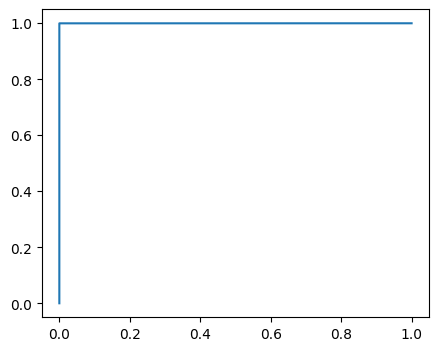

In [47]:
import sklearn.metrics as metrics

y_pred = rfc.predict(X_test)

Accuracy = metrics.accuracy_score(y_test, y_pred)
Precision = metrics.precision_score(y_test, y_pred)
Recall = metrics.recall_score(y_test, y_pred)
F1 = metrics.f1_score(y_test, y_pred)
fpr, tpr, threasholds = metrics.roc_curve(y_test, y_pred)
auroc = metrics.roc_auc_score(y_test, y_pred)
""" 
Confusion matrix:

      0  1 - predicted value (Wikipedia uses different convention for axes)
    0 TN FP
    1 FN TP 
"""
print(confusion_matrix(y_test, y_pred))
print(f'{Accuracy = }')
print(f'{Precision = }')
print(f'{Recall = }')
print(f"Area Under ROC Curve = {auroc}")
print(f'{F1 = }')
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr)
plt.show()

## Model saving

In [48]:
import pickle
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rfc, f)

## Intra-Dataset testing

We tested against CIC-IDS-2017 mostly as control - now we should evaluate performance against a similar dataset, the corrected CSE-CIC-IDS-2018

Open the previously saved model.

In [13]:
import pickle

import numpy as np
import pandas as pd
import sklearn.metrics as metrics

from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot as plt

In [4]:
with open('rf_model.pkl', 'rb') as f:
    rfc: RandomForestClassifier = pickle.load(f)
rfc

RandomForestClassifier(min_samples_leaf=2, n_estimators=70, n_jobs=-1,
                       oob_score=True, random_state=6)

In [5]:
#!wget https://intrusion-detection.distrinet-research.be/CNS2022/Datasets/CSECICIDS2018_improved.zip -O 2018dataset.zip
#!unzip -u -d Corrected_CSECICIDS2018/ 2018dataset.zip 

Due to the size of the dataset it is impossible to load it all at once.
So I define two functions that I can call easily on each file. 
Since we have the same characteristics, the data pipeline is the same as before minus the undersampling, and we directly selected the relevant features.


In [9]:
def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
    def clean_attempted(row):
        if row['Attempted Category'] != -1:
            row['Label'] = 'BENIGN'
        return row

    df = df.apply(clean_attempted, axis=1)
    df.drop(columns='Attempted Category', inplace=True)
    #print('Cleaned Attempted')

    df.drop(df[pd.isnull(df['Flow ID'])].index, inplace=True)

    df.replace('Infinity', -1, inplace=True)
    df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)

    df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

    df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

    le = LabelEncoder()
    string_features = list(df.select_dtypes(include=['object']).columns)
    df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))

    feats = list(rfc.feature_names_in_)
    feats.append('Label')
    return df[feats]

In [11]:
def eval_metrics(df: pd.DataFrame) -> None:

    y_test = df['Label']
    X_test = df.drop(columns='Label')
    #print('Predicting')
    y_pred = rfc.predict(X_test)

    #print('Computing scores')
    Accuracy = metrics.accuracy_score(y_test, y_pred)
    Precision = metrics.precision_score(y_test, y_pred)
    Recall = metrics.recall_score(y_test, y_pred)
    F1 = metrics.f1_score(y_test, y_pred)
    fpr, tpr, threasholds = metrics.roc_curve(y_test, y_pred)
    auroc = metrics.roc_auc_score(y_test, y_pred)
    """ 
    Confusion matrix:

        0  1 - predicted value (Wikipedia uses different convention for axes)
        0 TN FP
        1 FN TP 
    """
    print(metrics.confusion_matrix(y_test, y_pred))
    print(f'{Accuracy = }')
    print(f'{Precision = }')
    print(f'{Recall = }')
    print(f"Area Under ROC Curve = {auroc}")
    print(f'{F1 = }')
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr)
    plt.show()

Corrected_CSECICIDS2018/Friday-02-03-2018.csv
[[954477  22987]
 [ 22337    199]]
Accuracy = 0.954676
Precision = 0.008582765461916674
Recall = 0.008830315938942138
Area Under ROC Curve = 0.4926566686542636
F1 = 0.008704781068194743


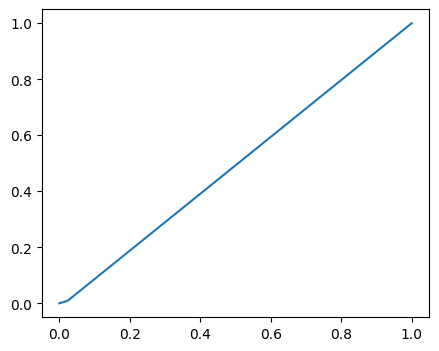

Corrected_CSECICIDS2018/Friday-16-02-2018.csv
[[722369  33620]
 [244011      0]]
Accuracy = 0.722369
Precision = 0.0
Recall = 0.0
Area Under ROC Curve = 0.47776422672816665
F1 = 0.0


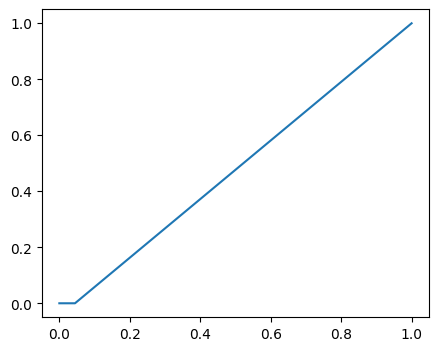

Corrected_CSECICIDS2018/Friday-23-02-2018.csv
[[975036  24937]
 [    27      0]]
Accuracy = 0.975036
Precision = 0.0
Recall = 0.0
Area Under ROC Curve = 0.4875311633414102
F1 = 0.0


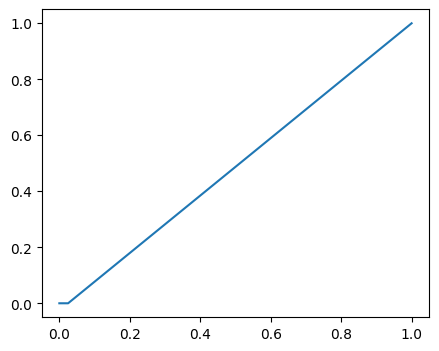

Corrected_CSECICIDS2018/Thursday-01-03-2018.csv
[[971548  22471]
 [   897   5084]]
Accuracy = 0.976632
Precision = 0.18450371983306116
Recall = 0.8500250794181575
Area Under ROC Curve = 0.9137094358448669
F1 = 0.30319656488549623


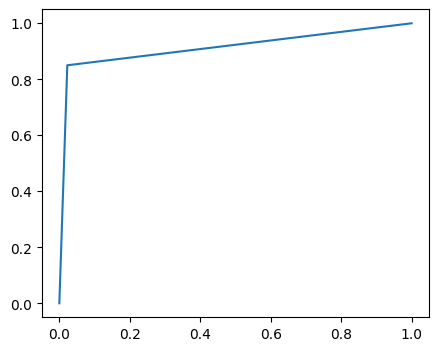

Corrected_CSECICIDS2018/Thursday-15-02-2018.csv
[[966709  27605]
 [  3916   1770]]
Accuracy = 0.968479
Precision = 0.06025531914893617
Recall = 0.3112908899050299
Area Under ROC Curve = 0.6417640151426158
F1 = 0.1009668862839052


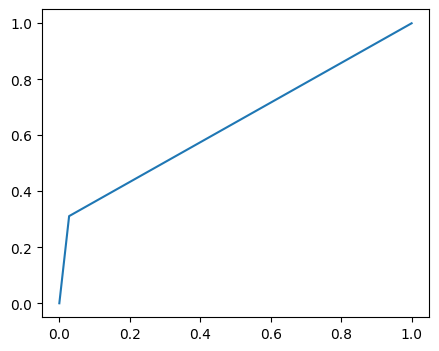

Corrected_CSECICIDS2018/Thursday-22-02-2018.csv
[[974823  25156]
 [    21      0]]
Accuracy = 0.974823
Precision = 0.0
Recall = 0.0
Area Under ROC Curve = 0.487421735856453
F1 = 0.0


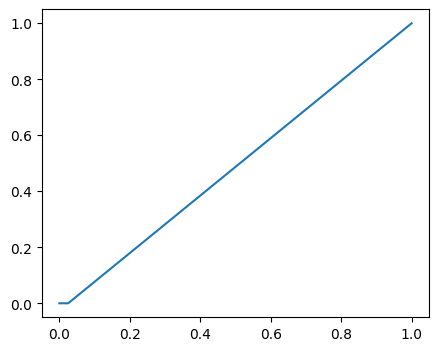

Corrected_CSECICIDS2018/Tuesday-20-02-2018.csv
[[927173  24996]
 [  2045  45786]]
Accuracy = 0.972959
Precision = 0.6468593710265321
Recall = 0.9572453011645168
Area Under ROC Curve = 0.9654968294307612
F1 = 0.7720233026733999


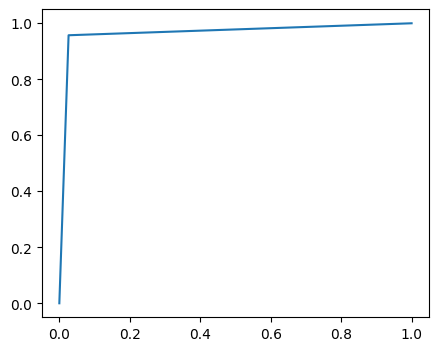

Corrected_CSECICIDS2018/Wednesday-14-02-2018.csv
[[926168  57764]
 [ 16068      0]]
Accuracy = 0.926168
Precision = 0.0
Recall = 0.0
Area Under ROC Curve = 0.4706463454791591
F1 = 0.0


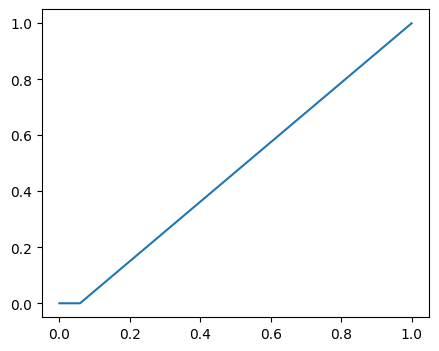

Corrected_CSECICIDS2018/Wednesday-21-02-2018.csv
[[823322  21127]
 [155547      4]]
Accuracy = 0.823326
Precision = 0.00018929534806682127
Recall = 2.5715038797564787e-05
Area Under ROC Curve = 0.4875035171092616
F1 = 4.527908898472963e-05


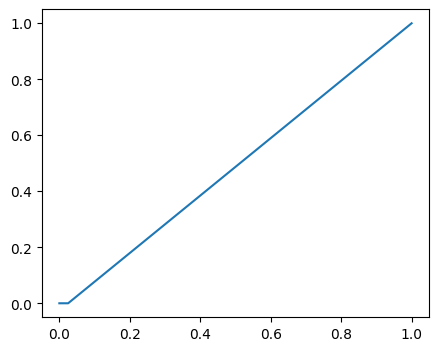

Corrected_CSECICIDS2018/Wednesday-28-02-2018.csv
[[969818  22545]
 [  1337   6300]]
Accuracy = 0.976118
Precision = 0.21840873634945399
Recall = 0.8249312557286893
Area Under ROC Curve = 0.9011063772675368
F1 = 0.3453758017652542


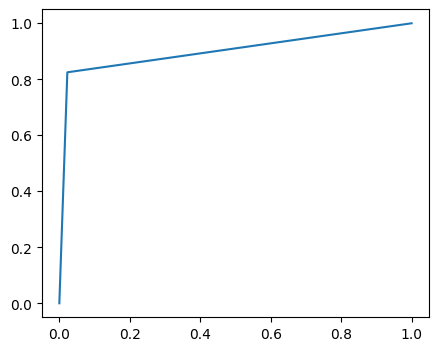

In [14]:
for filename in Path('./Corrected_CSECICIDS2018/').glob('*.csv'):
  print(f"{filename}")
  df = pd.read_csv(filename, index_col=0, encoding='latin').sample(1_000_000) # We only sample a milion because the whole file saturates the RAM and causes the computer to freeze
  #print(df.shape)
  df = prepare_data(df)
  eval_metrics(df)
  del df

# input("Press enter to continue")

From the testing on CSE-CIC-IDS-2018 is clear how, despite the exceptional performance on the i.i.d. test set, the trained model didn't learn any useful generalization: On the very similar dataset it performed extremely poorly: Looking at the confusion matrix, it almost never correctly identified the attacks. Partly this is due to the class imbalance: the accuracy score is 95%, and the high amount of false negatives show how our model favors guessing 'benign'. Not only that, but despite the low precision it also has a low recall: this suggests that the class imbalance might not have been the main problem, since it often mistakenly identified attacks.

While it mostly performed terribly, in some cases it did much better than expected. Most notably: Thursday-01-03 (low precision), Tuesday-20-02 (acceptable precision), Wednesday-28-02 (low precision). In  all of these three cases it had low precision (18%, 65%, 22%). 